<a href="https://colab.research.google.com/github/albuut/Medical-Malpractice-Analysis/blob/main/CS235_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
from matplotlib import pyplot

# Medical Malpractice Analysis

# Google Colab Startup
Make sure to clone the repository into the Google Colab.

In [ ]:
!git clone https://github.com/albuut/Medical-Malpractice-Analysis.git

fatal: destination path 'Medical-Malpractice-Analysis' already exists and is not an empty directory.


Run the following code.

In [ ]:
%cd /content/Medical-Malpractice-Analysis/
!pip install stepwise-regression
!pip install feature_engine
!pip install factor_analyzer

/content/Medical-Malpractice-Analysis


# Data Cleaning

Data manipulated from the original data set.

1. Amount: Log(Amount)

2. Speciality: Dummy variable encoded into different specialities.

3. Insurance: Dummy variable enconded into different insurances.

4. Marital Status: Dummy variable econded into different marital status.

5. Gender: One hot encoded gender for Male = 0 and Female = 1.

The data is also split into three categories.
1. Training: 60%
2. Validation: 20%
3. Testing: 20%

The decison to convert insurance and martial status to become dummy variable encoded was so that we did not have to worry about the numbering of the enumerated variables imply there was a form of ordinality.

Some things to consider for future development is to not remove the unknown's completely from the data set. There could be corrleations where divoriced people do not put their insurance information down. Future reticfication would be to think about how to assign some value to them. Another improvement could be using Stratified Sampling.





## proccess_data.py
```python
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

if(len(sys.argv) == 4):
    file_input = sys.argv[1]
    file_output = sys.argv[2]
    log_base = sys.argv[3]
else:
    errors.append("Invalid Number of Arguments")

if(len(errors) == 0):
    try:
        df = pd.read_csv(file_input)
    except Exception as e:
        errors.append("Invalid file input / Could not find file")
    
    if(len(errors) == 0):
        #Log the Data
        if log_base == '10':
            df['log_Amount'] = np.log10(df['Amount'])
        elif log_base == '2':
            df['log_Amount'] = np.log2(df['Amount'])
        elif log_base == 'ln':
            df['log_Amount'] = np.log(df['Amount'])
        else:
            errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
        col_move = df.pop('log_Amount')
        df.insert(loc=1,column='log_Amount',value=col_move)
if(len(errors) == 0):
    #Speciality
    df = dummy_variable_col(df,'Specialty')
    #Insurance
    df = df[df['Insurance'].str.contains("Unknown") == False]
    df = dummy_variable_col(df,'Insurance')
    #Marital Status
    df = df[df['Marital Status'] != 4]
    df = dummy_variable_col(df,'Marital Status')
    df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
    #Gender Binary Encode
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    
    #Shuffle Data and Split
    #Consider checking out stratified splitting
    train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])
    
    train = train.reset_index(drop=True) #60%
    validate = validate.reset_index(drop=True) #20%
    test = test.reset_index(drop=True) #20%
    
    total_data = len(train) + len(validate) + len(test)
    
    train.to_csv(file_output + '_train.csv', index=False)
    print("Successfully written data to: " + file_output + '_train.csv')
    validate.to_csv(file_output + '_validate.csv', index=False)
    print("Successfully written data to: " + file_output + '_validate.csv')
    test.to_csv(file_output + '_test.csv', index =False)
    print("Successfully written data to: " + file_output + '_test.csv')
    
else:
    for e in reversed(errors):
        print(e)
```

We can use the following lines to generate the cleaned up data from csv file with different log values down below.

In [ ]:
!python process_data.py medicalmalpractice.csv log10_data 10
!python process_data.py medicalmalpractice.csv log2_data 2
!python process_data.py medicalmalpractice.csv ln_data ln

Successfully written data to: log10_data_train.csv
Successfully written data to: log10_data_validate.csv
Successfully written data to: log10_data_test.csv
Successfully written data to: log2_data_train.csv
Successfully written data to: log2_data_validate.csv
Successfully written data to: log2_data_test.csv
Successfully written data to: ln_data_train.csv
Successfully written data to: ln_data_validate.csv
Successfully written data to: ln_data_test.csv


We then display the origonal data down below.

In [ ]:
df_original = pd.read_csv('medicalmalpractice.csv')
df_original

Amount  Severity  Age  Private Attorney  Marital Status  \
0       57041         7   62                 1               2   
1      324976         6   38                 1               2   
2      135383         4   34                 1               2   
3      829742         7   42                 1               1   
4      197675         3   60                 0               2   
...       ...       ...  ...               ...             ...   
79205   25305         4   64                 1               2   
79206   43098         3   87                 0               4   
79207   35398         3   81                 0               4   
79208  154228         9   19                 0               4   
79209  168298         7    4                 1               1   

                Specialty          Insurance  Gender  
0         Family Practice            Private    Male  
1                   OBGYN       No Insurance  Female  
2              Cardiology            Unknown    Male  
3              Pediatrics       No Insurance  Female  
4                   OBGYN  Medicare/Medicaid  Female  
...                   ...                ...     ...  
79205     General Surgery            Unknown    Male  
79206  Orthopedic Surgery            Unknown    Male  
79207      Anesthesiology            Unknown    Male  
79208         Dermatology            Unknown  Female  
79209     Family Practice            Private  Female  

[79210 rows x 8 columns]

We can then observe how the data is cleaned and seperated into different variables to be used in different forms of regression or analysis.

In [ ]:
df_log10 = pd.read_csv('log10_data_train.csv')
df_log10

Amount  log_Amount  Severity  Age  Private Attorney  Gender  \
0      142542    5.153943         4   65                 1       0   
1      110162    5.042032         4   72                 1       1   
2       85764    4.933305         3   28                 1       0   
3      204264    5.310192         3   48                 0       1   
4      172914    5.237830         3   47                 1       1   
...       ...         ...       ...  ...               ...     ...   
29519  103582    5.015284         3    9                 1       1   
29520   51143    4.708786         9   34                 1       1   
29521   46769    4.669958         2   70                 1       1   
29522   48367    4.684549         6    6                 1       1   
29523   65416    4.815684         4   17                 1       1   

       Anesthesiology  Cardiology  Dermatology  Emergency Medicine  ...  \
0                   0           0            0                   0  ...   
1                   0           0            0                   0  ...   
2                   0           0            0                   0  ...   
3                   0           0            0                   0  ...   
4                   0           1            0                   0  ...   
...               ...         ...          ...                 ...  ...   
29519               0           0            0                   0  ...   
29520               0           0            0                   0  ...   
29521               0           0            0                   0  ...   
29522               0           0            0                   0  ...   
29523               0           0            0                   0  ...   

       Thoracic Surgery  Urological Surgery  Medicare/Medicaid  No Insurance  \
0                     0                   0                  0             0   
1                     0                   0                  0             0   
2                     0                   0                  0             0   
3                     0                   0                  0             0   
4                     0                   0                  0             0   
...                 ...                 ...                ...           ...   
29519                 0                   0                  1             0   
29520                 0                   0                  0             0   
29521                 0                   0                  0             0   
29522                 1                   0                  0             0   
29523                 0                   0                  0             0   

       Private  Workers Compensation  Divorced  Single  Married  Widowed  
0            1                     0         0       0        1        0  
1            1                     0         0       1        0        0  
2            1                     0         0       0        1        0  
3            1                     0         0       0        1        0  
4            1                     0         0       1        0        0  
...        ...                   ...       ...     ...      ...      ...  
29519        0                     0         0       1        0        0  
29520        1                     0         0       0        1        0  
29521        1                     0         0       0        1        0  
29522        1                     0         0       1        0        0  
29523        1                     0         0       1        0        0  

[29524 rows x 34 columns]

# Bayesian Ridge Regression

Initalize variables and read data.

In [ ]:
base_file = 'log10_data'

#Untuned Bayesian Regression
base_regressor = BayesianRidge()
#Untuned Bayesian Regression with Transform
log_base_regressor = BayesianRidge()

#Tuned Bayesian Regression
tuned_regressor = BayesianRidge()
#Tuned Log Bayesian Regression
log_tuned_regressor = BayesianRidge()

#File suffixes
train_suffix = '_train.csv'
validate_suffix = '_validate.csv'
test_suffix = '_test.csv'

#Read Data from File
df_bay_train = pd.read_csv(base_file + train_suffix)
df_bay_validate = pd.read_csv(base_file + validate_suffix)
df_bay_test = pd.read_csv(base_file + test_suffix)

#Testing what happens when removing speciality
#df_bay_train = df_bay_train.drop(columns=df_bay_train.columns[6:26])
#df_bay_validate = df_bay_validate.drop(columns=df_bay_validate.columns[6:26])
#df_bay_test = df_bay_test.drop(columns=df_bay_test.columns[6:26])

#Extract our features and our Y
train_x, train_y, log_train_y = df_bay_train.drop(columns=['Amount','log_Amount']), df_bay_train['Amount'], df_bay_train['log_Amount']

#Seed values for initalized hyperparameters for RandomizedSearchCV
bayesian_param = {
    'alpha_init': np.linspace(1e-10,1e-2,num=100),
    'lambda_init': np.linspace(1e-10,1e-2,num=100),
    'alpha_1': np.linspace(1e-8,1e-2,num=100),
    'alpha_2': np.linspace(1e-8,1e-2,num=100),
    'lambda_1': np.linspace(1e-9,1e-2,num=100),
    'lambda_2':np.linspace(1e-4,1e-2,num=100)
}

Search for the best hyperparameters using RandomizedSearchCV and establishing the models.

In [ ]:
#Randomized Search to find the best hyperparameters without transform
tuned_cv = RandomizedSearchCV(tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
tuned_cv.fit(train_x,train_y)
tuned_param = tuned_cv.best_params_

#Randomized Search to find the best hyperparameters with transform
log_tuned_cv = RandomizedSearchCV(log_tuned_regressor, param_distributions=bayesian_param,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
log_tuned_cv.fit(train_x,log_train_y)
log_tuned_param = log_tuned_cv.best_params_

#Model with hyperparamters
tuned_model = BayesianRidge(alpha_init = tuned_param['alpha_init'], lambda_init = tuned_param['lambda_init'], alpha_1 = tuned_param['alpha_1'], alpha_2 = tuned_param['alpha_2'], lambda_1 = tuned_param['lambda_1'], lambda_2 = tuned_param['lambda_2'])
tuned_model.fit(train_x,train_y)

#Log model with hyperparameters
log_tuned_model = BayesianRidge(alpha_init = log_tuned_param['alpha_init'], lambda_init = log_tuned_param['lambda_init'], alpha_1 = log_tuned_param['alpha_1'], alpha_2 = log_tuned_param['alpha_2'], lambda_1 = log_tuned_param['lambda_1'], lambda_2 = log_tuned_param['lambda_2'])
log_tuned_model.fit(train_x, log_train_y)

#Base Regressors
base_regressor.fit(train_x,train_y)
log_base_regressor.fit(train_x, log_train_y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


BayesianRidge()

Use our validation data to determine the performance of our different models.

In [ ]:
#Extract Data from the Validation data set to train the hyperparameter
validate_x, validate_y, log_validate_y = df_bay_validate.drop(columns=['Amount','log_Amount']), df_bay_validate['Amount'], df_bay_validate['log_Amount']

#Predict off the validaton data
base_bay_predict_validate = base_regressor.predict(validate_x)
log_bay_predict_validate = log_base_regressor.predict(validate_x)
tuned_bay_predict_validate = tuned_model.predict(validate_x)
log_tuned_bay_predict_validate = log_tuned_model.predict(validate_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,base_bay_predict_validate))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_bay_predict_validate))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(validate_y,tuned_bay_predict_validate))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_validate_y,log_tuned_bay_predict_validate))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(validate_y - base_bay_predict_validate))
log_bay_predict_mae = np.mean(np.abs(log_validate_y - log_bay_predict_validate))
tuned_bay_predict_mae = np.mean(np.abs(validate_y - tuned_bay_predict_validate))
log_tuned_bay_predict_mae = np.mean(np.abs(log_validate_y - log_tuned_bay_predict_validate))

#Find Mean
validate_y_mean = np.mean(validate_y)
log_validate_y_mean = np.mean(log_validate_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", base_bay_predict_rmse)
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", tuned_bay_predict_rmse)

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", log_bay_predict_rmse)
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", log_tuned_bay_predict_rmse)


print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(validate_y, base_bay_predict_validate, equal_var=True)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(validate_y, tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_bay_predict_validate)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_validate_y, log_tuned_bay_predict_validate)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 129272.216120899
Base RMSE: 177289.12060997705
Tuned MAE: 129272.21589614364
Tuned RMSE: 177289.12060410724

Log Transform
Base MAE: 0.3091162796598982
Base RMSE: 0.38988100103184087
Tuned MAE: 0.30911566105511007
Tuned RMSE: 0.3898805086615921

Base Stat
T Value: 0.618312964304542
P value: 0.5363762125637848
Tuned T Value: 0.6183129659566756
Tuned P value: 0.5363762114749585

Log Transform Stat
T Value: 0.5931510673613377
P value: 0.553086872261628
Tuned T Value: 0.593147950035788
Tuned P value: 0.5530889582668268

P value is larger than 0.05, we cannot reject null hypothesis


Lets run an additional prediction on our remaining 20% data that we haven't seen  to make sure our data is not overfitted. This time we are only testing our log tuned since it has a better MAE. However, it should not matter much since the tuned and based are almost indentical.

In [ ]:
test_x, test_y, log_test_y = df_bay_test.drop(columns=['Amount','log_Amount']), df_bay_test['Amount'], df_bay_test['log_Amount']
#Predict off the validaton data
base_bay_predict_test = base_regressor.predict(test_x)
log_bay_predict_test = log_base_regressor.predict(test_x)
tuned_bay_predict_test = tuned_model.predict(test_x)
log_tuned_bay_predict_test = log_tuned_model.predict(test_x)

#Check MSE
base_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,base_bay_predict_test))
log_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_bay_predict_test))
tuned_bay_predict_rmse = np.sqrt(mean_squared_error(test_y,tuned_bay_predict_test))
log_tuned_bay_predict_rmse = np.sqrt(mean_squared_error(log_test_y,log_tuned_bay_predict_test))

#Check MAE
base_bay_predict_mae = np.mean(np.abs(test_y - base_bay_predict_test))
log_bay_predict_mae = np.mean(np.abs(log_test_y - log_bay_predict_test))
tuned_bay_predict_mae = np.mean(np.abs(test_y - tuned_bay_predict_test))
log_tuned_bay_predict_mae = np.mean(np.abs(log_test_y - log_tuned_bay_predict_test))

#Find Mean
test_y_mean = np.mean(test_y)
log_test_y_mean = np.mean(log_test_y)

print("No Transform")
print("Base MAE:", base_bay_predict_mae)
print("Base RMSE:", base_bay_predict_rmse)
print("Tuned MAE:", tuned_bay_predict_mae)
print("Tuned RMSE:", tuned_bay_predict_rmse)

print()

print("Log Transform")
print("Base MAE:", log_bay_predict_mae)
print("Base RMSE:", log_bay_predict_rmse)
print("Tuned MAE:", log_tuned_bay_predict_mae)
print("Tuned RMSE:", log_tuned_bay_predict_rmse)

print()
print('Base Stat')
t_statistic, p_value = stats.ttest_ind(test_y, base_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(test_y, tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()
print('Log Transform Stat')
t_statistic, p_value = stats.ttest_ind(log_test_y, log_bay_predict_test)
print('T Value:', t_statistic)
print('P value:', p_value)
t_statistic, p_value = stats.ttest_ind(log_test_y, log_tuned_bay_predict_test)
print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)
print()

if p_value < 0.05:
  print('P Value is smaller than 0.05, we can reject null hypothesis')
else:
  print('P value is larger than 0.05, we cannot reject null hypothesis')

No Transform
Base MAE: 129272.216120899
Base RMSE: 177289.12060997705
Tuned MAE: 129272.21589614364
Tuned RMSE: 177289.12060410724

Log Transform
Base MAE: 0.3091162796598982
Base RMSE: 0.38988100103184087
Tuned MAE: 0.30911566105511007
Tuned RMSE: 0.3898805086615921

Base Stat
T Value: 0.618312964304542
P value: 0.5363762125637848
Tuned T Value: 0.6183129659566756
Tuned P value: 0.5363762114749585

Log Transform Stat
T Value: 0.5931510673613377
P value: 0.553086872261628
Tuned T Value: 0.593147950035788
Tuned P value: 0.5530889582668268

P value is larger than 0.05, we cannot reject null hypothesis


From the P value being greater than 0.05 we cannot reject the null hypothesis. Therefore, we can say that the means of our predicator and ground truths are the same, meaning it is statistically significant. OUR RMSE and MAE being relatively low means that our estimator functions are good predictors.

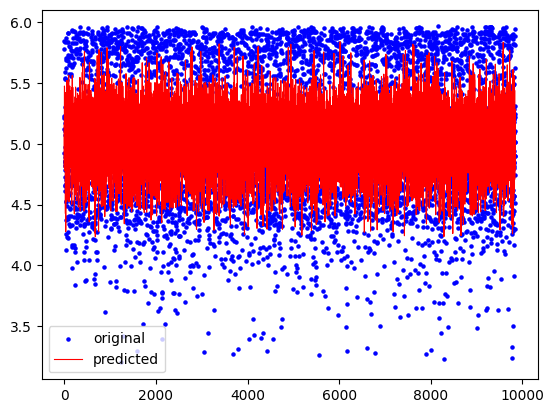

In [ ]:
#Idea from https://www.datatechnotes.com/2019/11/bayesian-ridge-regression-example-in.html
x_ax = range(len(log_test_y))
pyplot.scatter(x_ax, log_test_y, s=5, color="blue", label="original")
pyplot.plot(x_ax, log_tuned_bay_predict_test, lw=0.8, color="red", label="predicted")
pyplot.legend()
pyplot.show()

## Bayesian Linear Regression From Scratch

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools

#partial code from ChatGPT
class BayesianLinearRegression:
    def __init__(self, alpha=1, beta=1, noise_variance=1, lambda_reg=1):
        self.alpha = alpha
        self.beta = beta
        self.noise_variance = noise_variance
        self.lambda_reg = lambda_reg
        self.posterior_mean = None
        self.posterior_covariance = None

    #partial code from ChatGPT for Fit such as the posterior_precision and mean
    def fit(self, X, y):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        n, p = X_data.shape

        #B function
        design_mat = X_data.values

        #Weak Learner Prior
        precision_matrix_prior = np.eye(p) * self.beta
        mean_prior = np.ones(p) * self.alpha

        #L2 Regulraization factor
        regularization_term = self.lambda_reg * np.eye(p)

        #Finding Posterior Precision
        # (1 / self.noise_variance) * design_mat.T @ design_mat = likihood
        # prior term = precision_matrix_prior
        # Regularization_term
        posterior_precision = precision_matrix_prior + (1 / self.noise_variance) * design_mat.T @ design_mat + regularization_term
        # Covariance = Inverse of Posterior Precision
        posterior_covariance = np.linalg.inv(posterior_precision)
        # Weight Function of B
        posterior_mean = posterior_covariance @ (precision_matrix_prior @ mean_prior + (1 / self.noise_variance) * design_mat.T @ y)

        self.posterior_mean = posterior_mean
        self.posterior_covariance = posterior_covariance
        return self

    def predict(self, X):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        design_mat = X_data.values

        #Feature X dotted with Means to generate values, Error should already be included.
        y_pred_mean = design_mat @ self.posterior_mean

        return y_pred_mean

# Read Data from File
df_train = pd.read_csv('log10_data_train.csv')
df_validate = pd.read_csv('log10_data_validate.csv')

# Split the data into training and validation sets
train_x, train_y, log_train_y = df_train.drop(columns=['Amount','log_Amount']), df_train['Amount'], df_train['log_Amount']
validate_x, validate_y, log_validate_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

# Define hyperparameter values
alpha_values = np.logspace(-4, 0, 5)
beta_values = np.logspace(-4, 0, 5)
noise_variance_values = np.logspace(0, 5, 6)
lambda_reg_values = np.logspace(0, 5, 6)

# Create all combinations of hyperparameters
hyperparameter_combinations = itertools.product(alpha_values, beta_values, noise_variance_values, lambda_reg_values)

best_params = None
best_rmse = float('inf')

# Iterate over hyperparameter combinations
for alpha, beta, noise_variance, lambda_reg in hyperparameter_combinations:
    model = BayesianLinearRegression(alpha=alpha, beta=beta, noise_variance=noise_variance, lambda_reg=lambda_reg)
    model.fit(train_x, log_train_y)
    y_pred = model.predict(validate_x)
    mse = mean_squared_error(log_validate_y, y_pred)
    rmse = np.sqrt(mse)

    print(f'alpha={alpha}, beta={beta}, noise_variance={noise_variance}, lambda_reg={lambda_reg}, RMSE={rmse}')

    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'alpha': alpha, 'beta': beta, 'noise_variance': noise_variance, 'lambda_reg': lambda_reg}

print('Best hyperparameters:', best_params)
print(best_rmse)


alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=1.0, RMSE=0.38986566833070896
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=10.0, RMSE=0.38987694016128843
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=100.0, RMSE=0.3927271575620508
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=1000.0, RMSE=0.4917520932400352
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=10000.0, RMSE=0.9365769379974463
alpha=0.0001, beta=0.0001, noise_variance=1.0, lambda_reg=100000.0, RMSE=1.4458163646987572
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=1.0, RMSE=0.38987694427979275
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=10.0, RMSE=0.39272720633192326
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=100.0, RMSE=0.49175219646160484
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=1000.0, RMSE=0.9365769599910716
alpha=0.0001, beta=0.0001, noise_variance=10.0, lambda_reg=10000.0, RMSE=1.445816366532868
alpha=0.0

In [ ]:
base_model = BayesianLinearRegression()
tuned_model = BayesianLinearRegression(alpha = best_params['alpha'], beta = best_params['beta'], noise_variance = best_params['noise_variance'], lambda_reg = best_params['lambda_reg'])

base_model.fit(X_train, y_train)
tuned_model.fit(X_train, y_train)

df_test = pd.read_csv('log10_data_test.csv')
test_x, test_y, log_test_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

base_predict = base_model.predict(test_x)
tuned_predict = tuned_model.predict(test_x)

base_mse = mean_squared_error(log_validate_y.values, base_predict)
base_rmse = np.sqrt(base_mse)
tuned_mse = mean_squared_error(log_validate_y.values, tuned_predict)
tuned_rmse = np.sqrt(tuned_mse)

base_mae = np.mean(np.abs(log_test_y - base_predict))
tuned_mae = np.mean(np.abs(log_test_y - tuned_predict))

print("Base RMSE:", base_rmse)
print("Tuned RMSE:", tuned_rmse)
print("Base MAE:", base_mae)
print("Tuned MAE:", tuned_mae)

print()

t_statistic, p_value = stats.ttest_ind(log_test_y, base_predict)

print('Base T Value:', t_statistic)
print('Base P value:', p_value)

t_statistic, p_value = stats.ttest_ind(log_test_y, tuned_predict)

print('Tuned T Value:', t_statistic)
print('Tuned P value:', p_value)

Base RMSE: 0.38995882469439497
Tuned RMSE: 0.3899545905704418
Base MAE: 0.3091663205259694
Tuned MAE: 0.3091870556646483

Base T Value: 0.7279561546502551
Base P value: 0.4666490863452577
Tuned T Value: 0.7494731763378439
Tuned P value: 0.45358101762898806


## Generating Different Data Sets

In [ ]:
import pandas as pd
import numpy as np
import sys

def dummy_variable_col(df, col):
    df_temp = pd.get_dummies(df[col])
    df_temp = df_temp.astype(int)
    df = pd.concat([df,df_temp],axis=1,).reindex(df.index)
    df.drop(col,axis=1,inplace=True)
    return df

## python3 function_name input output log_base
errors = []

for i in range(5):
  if(len(errors) == 0):
      file_input = "medicalmalpractice.csv"
      file_output = "data_" + str(i)
      log_base = "10"
      try:
          df = pd.read_csv(file_input)
      except Exception as e:
          errors.append("Invalid file input / Could not find file")

      if(len(errors) == 0):
          #Log the Data
          if log_base == '10':
              df['log_Amount'] = np.log10(df['Amount'])
          elif log_base == '2':
              df['log_Amount'] = np.log2(df['Amount'])
          elif log_base == 'ln':
              df['log_Amount'] = np.log(df['Amount'])
          else:
              errors.append('Invalid 3rd Argument: Use 10, 2, or ln')
          col_move = df.pop('log_Amount')
          df.insert(loc=1,column='log_Amount',value=col_move)
  if(len(errors) == 0):
      np.random.seed(42+i*3)
      #Speciality
      df = dummy_variable_col(df,'Specialty')
      #Insurance
      df = df[df['Insurance'].str.contains("Unknown") == False]
      df = dummy_variable_col(df,'Insurance')
      #Marital Status
      df = df[df['Marital Status'] != 4]
      df = dummy_variable_col(df,'Marital Status')
      df = df.rename(columns={0:'Divorced', 1:'Single', 2:'Married', 3:'Widowed'})
      #Gender Binary Encode
      df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

      #Shuffle Data and Split
      #Consider checking out stratified splitting
      train, validate, test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(.8*len(df))])

      train = train.reset_index(drop=True) #60%
      validate = validate.reset_index(drop=True) #20%
      test = test.reset_index(drop=True) #20%

      total_data = len(train) + len(validate) + len(test)

      train.to_csv(file_output + '_train.csv', index=False)
      print("Successfully written data to: " + file_output + '_train.csv')
      validate.to_csv(file_output + '_validate.csv', index=False)
      print("Successfully written data to: " + file_output + '_validate.csv')
      test.to_csv(file_output + '_test.csv', index =False)
      print("Successfully written data to: " + file_output + '_test.csv')

  else:
      for e in reversed(errors):
          print(e)

Successfully written data to: data_0_train.csv
Successfully written data to: data_0_validate.csv
Successfully written data to: data_0_test.csv
Successfully written data to: data_1_train.csv
Successfully written data to: data_1_validate.csv
Successfully written data to: data_1_test.csv
Successfully written data to: data_2_train.csv
Successfully written data to: data_2_validate.csv
Successfully written data to: data_2_test.csv
Successfully written data to: data_3_train.csv
Successfully written data to: data_3_validate.csv
Successfully written data to: data_3_test.csv
Successfully written data to: data_4_train.csv
Successfully written data to: data_4_validate.csv
Successfully written data to: data_4_test.csv


## Testing Different Data Sets

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import itertools

class BayesianLinearRegression:
    def __init__(self, alpha=1, beta=1, noise_variance=1, lambda_reg=1):
        self.alpha = alpha
        self.beta = beta
        self.noise_variance = noise_variance
        self.lambda_reg = lambda_reg
        self.posterior_mean = None
        self.posterior_covariance = None

    def fit(self, X, y):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        n, p = X_data.shape

        design_mat = X_data.values
        precision_matrix_prior = np.eye(p) * self.beta
        mean_prior = np.ones(p) * self.alpha
        regularization_term = self.lambda_reg * np.eye(p)

        posterior_precision = precision_matrix_prior + (1 / self.noise_variance) * design_mat.T @ design_mat + regularization_term
        posterior_covariance = np.linalg.inv(posterior_precision)
        posterior_mean = posterior_covariance @ (precision_matrix_prior @ mean_prior + (1 / self.noise_variance) * design_mat.T @ y)

        self.posterior_mean = posterior_mean
        self.posterior_covariance = posterior_covariance
        return self

    def predict(self, X):
        X_data = X.copy()
        X_data.insert(0, 'B0', 1)
        design_mat = X_data.values
        y_pred_mean = design_mat @ self.posterior_mean

        return y_pred_mean

for i in range(5):
  # Read Data from File
  df_train = pd.read_csv('data_' + str(i) + '_train.csv')
  df_validate = pd.read_csv('data_' + str(i) + '_validate.csv')

  # Split the data into training and validation sets
  train_x, train_y, log_train_y = df_train.drop(columns=['Amount','log_Amount']), df_train['Amount'], df_train['log_Amount']
  validate_x, validate_y, log_validate_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

  # Define hyperparameter values
  alpha_values = np.logspace(-4, 0, 5)
  beta_values = np.logspace(-4, 0, 5)
  noise_variance_values = np.logspace(0, 5, 6)
  lambda_reg_values = np.logspace(0, 5, 6)

  # Create all combinations of hyperparameters
  hyperparameter_combinations = itertools.product(alpha_values, beta_values, noise_variance_values, lambda_reg_values)

  best_params = None
  best_rmse = float('inf')

  # Iterate over hyperparameter combinations
  for alpha, beta, noise_variance, lambda_reg in hyperparameter_combinations:
      model = BayesianLinearRegression(alpha=alpha, beta=beta, noise_variance=noise_variance, lambda_reg=lambda_reg)
      model.fit(train_x, log_train_y)
      y_pred = model.predict(validate_x)
      mse = mean_squared_error(log_validate_y, y_pred)
      rmse = np.sqrt(mse)

      #print(f'alpha={alpha}, beta={beta}, noise_variance={noise_variance}, lambda_reg={lambda_reg}, RMSE={rmse}')

      if rmse < best_rmse:
          best_rmse = rmse
          best_params = {'alpha': alpha, 'beta': beta, 'noise_variance': noise_variance, 'lambda_reg': lambda_reg}
  print(i)
  print('Best hyperparameters:', best_params)

  base_model = BayesianLinearRegression()
  tuned_model = BayesianLinearRegression(alpha = best_params['alpha'], beta = best_params['beta'], noise_variance = best_params['noise_variance'], lambda_reg = best_params['lambda_reg'])

  base_model.fit(X_train, y_train)
  tuned_model.fit(X_train, y_train)

  df_test = pd.read_csv('data_' + str(i) + '_test.csv')
  test_x, test_y, log_test_y = df_validate.drop(columns=['Amount', 'log_Amount']), df_validate['Amount'], df_validate['log_Amount']

  base_predict = base_model.predict(test_x)
  tuned_predict = tuned_model.predict(test_x)

  base_mse = mean_squared_error(log_validate_y.values, base_predict)
  base_rmse = np.sqrt(base_mse)
  tuned_mse = mean_squared_error(log_validate_y.values, tuned_predict)
  tuned_rmse = np.sqrt(tuned_mse)

  base_mae = np.mean(np.abs(log_test_y - base_predict))
  tuned_mae = np.mean(np.abs(log_test_y - tuned_predict))

  print("Base RMSE:", base_rmse)
  print("Tuned RMSE:", tuned_rmse)
  print("Base MAE:", base_mae)
  print("Tuned MAE:", tuned_mae)

  print()

  t_statistic, p_value = stats.ttest_ind(log_test_y, base_predict)

  print('Base T Value:', t_statistic)
  print('Base P value:', p_value)

  t_statistic, p_value = stats.ttest_ind(log_test_y, tuned_predict)

  print('Tuned T Value:', t_statistic)
  print('Tuned P value:', p_value)
  print()

0
Best hyperparameters: {'alpha': 1.0, 'beta': 0.0001, 'noise_variance': 1.0, 'lambda_reg': 1.0}
Base RMSE: 0.389514683736443
Tuned RMSE: 0.38951205917230763
Base MAE: 0.30915659277245094
Tuned MAE: 0.30914718597634566

Base T Value: 1.303846419740506
Base P value: 0.19230120250269683
Tuned T Value: 1.2998513961865252
Tuned P value: 0.19366713046134937

1
Best hyperparameters: {'alpha': 1.0, 'beta': 1.0, 'noise_variance': 10.0, 'lambda_reg': 1.0}
Base RMSE: 0.38785866694353577
Tuned RMSE: 0.387880038299446
Base MAE: 0.3081807161547258
Tuned MAE: 0.30850265207746214

Base T Value: 0.20578289792469004
Base P value: 0.8369626292975985
Tuned T Value: 0.47657100165070776
Tuned P value: 0.6336729279523949

2
Best hyperparameters: {'alpha': 0.0001, 'beta': 1.0, 'noise_variance': 1.0, 'lambda_reg': 1.0}
Base RMSE: 0.38630382798378565
Tuned RMSE: 0.38630028734522914
Base MAE: 0.3058033930489782
Tuned MAE: 0.30581942129170764

Base T Value: 0.661995109254235
Base P value: 0.5079821073708565
Tune

From the P value being greater than 0.05 we cannot reject the null hypothesis. Therefore, we can say that the means of our predicator and ground truths are the same, meaning it is statistically significant. OUR RMSE and MAE being relatively low means that our estimator functions are good predictors. This one currently has similar RMSE and MAE from SKlearn when tuned so it has a comperable performance.

# Decision Tree Regression

Set up the training, testing, and validation datasets

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

log10_X_train = pd.read_csv('log10_data_train.csv')
log10_X_validate = pd.read_csv('log10_data_validate.csv')
log10_X_test = pd.read_csv('log10_data_test.csv')
log10_Y_train = log10_X_train['Amount']
log10_Y_validate = log10_X_validate['Amount']
log10_Y_test = log10_X_test['Amount']

Find the best parameters

In [ ]:
dt_params = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3, 0.4],
    'random_state': [1]
}


log10_model_test = DecisionTreeRegressor()
proposed_cv = RandomizedSearchCV(log10_model_test, param_distributions=dt_params,n_iter=100, cv=10, verbose=1,n_jobs=10,random_state=1)
proposed_cv.fit(log10_X_train,log10_Y_train)
proposed_param = proposed_cv.best_params_

Train the models

In [ ]:
log10_model = DecisionTreeRegressor()
log10_model_proposed = DecisionTreeRegressor(max_depth=40, min_samples_split=5, min_samples_leaf=2, criterion='poisson', random_state=1)

log10_model.fit(log10_X_train, log10_Y_train)
log10_model_proposed.fit(log10_X_train, log10_Y_train)

DecisionTreeRegressor(criterion='poisson', max_depth=40, min_samples_leaf=2,
                      min_samples_split=5, random_state=1)

Predict for validation set and calculate metrics

In [ ]:
log10_pred = log10_model.predict(log10_X_validate)
log10_pred_proposed = log10_model_proposed.predict(log10_X_validate)

log10_Y_validate_arr = log10_Y_validate.to_numpy()

log10_rmse = np.sqrt(mean_squared_error(log10_Y_validate, log10_pred))
log10_mae = mean_absolute_error(log10_Y_validate, log10_pred)

log10_rmse_proposed = np.sqrt(mean_squared_error(log10_Y_validate, log10_pred_proposed))
log10_mae_proposed = mean_absolute_error(log10_Y_validate, log10_pred_proposed)



log10_t_statistic, log10_p_value = ttest_ind(log10_Y_validate_arr, log10_pred)
log10_t_statistic_proposed, log10_p_value_proposed = ttest_ind(log10_Y_validate_arr, log10_pred_proposed)


print(log10_rmse)
print(log10_mae)
print(log10_t_statistic)
print(log10_p_value)

print(log10_rmse_proposed)
print(log10_mae_proposed)
print(log10_t_statistic_proposed)
print(log10_p_value_proposed)

74.75212782052698
28.1551513919935
3.593832066155449e-05
0.9999713257330309
75.80179671904287
31.41980796586053
1.7229578843447547e-05
0.9999862529596679


Optionally display the generated tree

[Text(0.6367110323115814, 0.9722222222222222, 'x[1] <= 5.428\npoisson = 91377.413\nsamples = 29524\nvalue = 186926.423'),
 Text(0.37108011260777635, 0.9166666666666666, 'x[1] <= 4.906\npoisson = 15884.733\nsamples = 23910\nvalue = 94291.358'),
 Text(0.15286673877441148, 0.8611111111111112, 'x[1] <= 4.592\npoisson = 5451.742\nsamples = 10425\nvalue = 44050.883'),
 Text(0.05718804710103235, 0.8055555555555556, 'x[1] <= 4.273\npoisson = 2428.958\nsamples = 4505\nvalue = 24140.433'),
 Text(0.01891428442267228, 0.75, 'x[1] <= 3.957\npoisson = 1176.865\nsamples = 1305\nvalue = 10953.207'),
 Text(0.00733680464229353, 0.6944444444444444, 'x[0] <= 4991.0\npoisson = 454.1\nsamples = 461\nvalue = 5463.993'),
 Text(0.0031932206733298264, 0.6388888888888888, 'x[1] <= 3.498\npoisson = 148.398\nsamples = 199\nvalue = 3332.352'),
 Text(0.0015781167806417674, 0.5833333333333334, 'x[0] <= 2347.5\npoisson = 45.328\nsamples = 86\nvalue = 2372.163'),
 Text(0.0007561809573908469, 0.5277777777777778, 'x[1] <

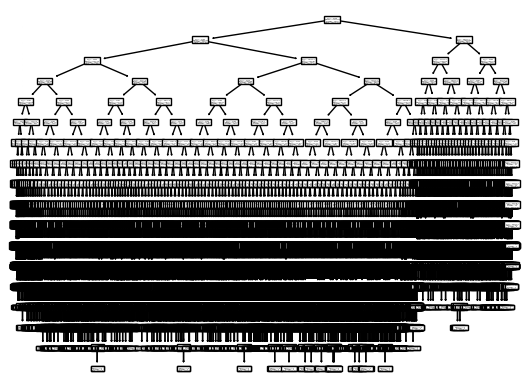

In [ ]:
plot_tree(log10_model_proposed)

#Scratch Decision Tree Regression

Now from scratch

In [ ]:
import numpy as np
#I got some inspiration for the structure from this video https://www.youtube.com/watch?v=P2ZB8c5Ha1Q as well as generative AI (ChatGPT/Google Bard)
#However I did not copy code directly from these sources

class DecisionTreeRegression:
  #Hardcoding in hyperparameters that I found earlier
  def __init__(self, max_depth=9999, min_samples_split=2, min_samples_leaf=1):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.min_samples_leaf = min_samples_leaf
    self.tree = None


  def make_tree(self, X, Y, depth):
    samples, features = X.shape
    #Return leaf node if 1. node is pure 2. node has below the minimum samples to split or 3. node is at the max depth
    if len(np.unique(Y)) == 1 or samples < self.min_samples_split or depth >= self.max_depth:
        return {'value': np.mean(Y)}

    split_feature, threshold = self.split(X, Y)
    #Return leaf node if no split is possible
    if split_feature is None or threshold is None:
        return {'value': np.mean(Y)}

    #Boolean mask on X
    #Learned from here https://jakevdp.github.io/PythonDataScienceHandbook/02.06-boolean-arrays-and-masks.html
    left = X[:, split_feature] <= threshold #True for all rows in X where X['split_feature'] <= threshold, False otherwise
    right = ~left #Complement mask of left
    #Return leaf node if the best split leads to children that are too small
    if np.sum(left) < self.min_samples_leaf or np.sum(right) < self.min_samples_leaf:
        return{'value': np.mean(Y)}

    #Otherwise recursively make subtrees
    left_subtree = self.make_tree(X[left], Y[left], depth + 1)
    right_subtree = self.make_tree(X[right], Y[right], depth + 1)

    return {'feature': split_feature, 'threshold': threshold, 'left_subtree': left_subtree, 'right_subtree': right_subtree}


  def split(self, X, Y):
    samples, features = X.shape
    #Return nothing we have nothing to split
    if samples < 2:
        return None, None

    max_deviance_change = 0
    best_feature = None
    best_threshold = None
    deviance = mse(Y)
    for feature in range(features):
      #Find all unique entries for the feature
      unique = np.unique(X[:,feature])
      splits = []
      #Generate all possible splits based on midpoints between unique entries
      for i in range(len(unique)-1):
        splits.append(((unique[i]+unique[i+1])/2))
      splits = np.array(splits)

      for threshold in splits:
          left = X[:, feature] <= threshold
          right = ~left
          #Skip testing the split if one side is too small
          if np.sum(left) < self.min_samples_split or np.sum(right) < self.min_samples_split:
              continue
          #Test deviance change of each split
          deviance_change = deviance - mse(Y[left]) - mse(Y[right])
          if deviance_change > max_deviance_change:
              max_deviance_change = deviance_change
              best_feature = feature
              best_threshold = threshold

    return best_feature, best_threshold


  def predict_sample(self, node, X_sample):
    #If node is a leaf, return its value
    if 'value' in node:
        return node['value']
    #Otherwise test against it's threshold and go further down the tree
    if X_sample[node['feature']] <= node['threshold']:
        return self.predict_sample(node['left_subtree'], X_sample)
    else:
        return self.predict_sample(node['right_subtree'], X_sample)

  def predict(self, X):
    return np.array([self.predict_sample(self.tree, sample) for sample in X])


  def fit(self, X, Y):
    self.tree = self.make_tree(X, Y, depth=0)


#Poisson deviance formula pulled from https://grodri.github.io/glms/notes/a2s5 item B.27
#Same as https://thestatsgeek.com/2014/04/26/deviance-goodness-of-fit-test-for-poisson-regression/
#Not sure if it is the correct formula since there are a lot of different ones I saw
def poisson_deviance(Y):
  mean = np.mean(Y)
  deviance = 2 * np.sum(Y * np.log(Y/mean) - (Y - mean))
  return deviance

#Mean squared error for baseline
def mse(Y):
  mean = np.mean(Y)
  mse = np.mean((Y - mean)**2)
  return mse

Train the model

In [ ]:
log10_model_scratch = DecisionTreeRegression()
log10_X_train_np = log10_X_train.to_numpy()
log10_Y_train_np = log10_Y_train.to_numpy()
log10_model_scratch.fit(log10_X_train_np, log10_Y_train_np)

Test prediction and output metrics

In [ ]:
log10_X_validate_np = log10_X_validate.to_numpy()
log10_pred_scratch = log10_model_scratch.predict(log10_X_validate_np)
log10_Y_validate_np = log10_Y_validate.to_numpy()

log10_rmse_scratch = np.sqrt(mean_squared_error(log10_Y_validate_np, log10_pred_scratch))
log10_mae_scratch = mean_absolute_error(log10_Y_validate_np, log10_pred_scratch)
log10_t_statistic_scratch, log10_p_value_scratch = ttest_ind(log10_Y_validate_np, log10_pred_scratch)
print(log10_rmse_scratch)
print(log10_mae_scratch)
print(log10_t_statistic_scratch)
print(log10_p_value_scratch)

63.248538394040416
25.85176811633569
0.00014946060240049187
0.9998807492080689


# Stepwise Regression



Import necessary libraries and read in preprocessed data files.

In [ ]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
from stepwise_regression import step_reg
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv("log10_data_train.csv")
df_validate = pd.read_csv("log10_data_validate.csv")
df_test = pd.read_csv("log10_data_test.csv")

We consider all features except for 'Amount' and 'log_Amount', then set 'log_Amount' to be the target variable. We will see which features significantly impact 'log_Amount the most'

In [ ]:
# consider all features (independent variables) except for 'Amount' and 'log_Amount'
X = df.drop(['log_Amount', 'Amount'], axis=1)

# 'log_Amount' is the dependent variable here
# the goal is to see which independent variables signficantly impact the dependent variable
y = df['log_Amount']

# add a constant to intercept X
X = sm.add_constant(X)

Create a basic linear regression model using our variables. Compute the RMSE and MAE of the baseline model predictions.

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     397.6
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:43:05   Log-Likelihood:                -14103.
No. Observations:               29524   AIC:                         2.827e+04
Df Residuals:                   29494   BIC:                         2.852e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

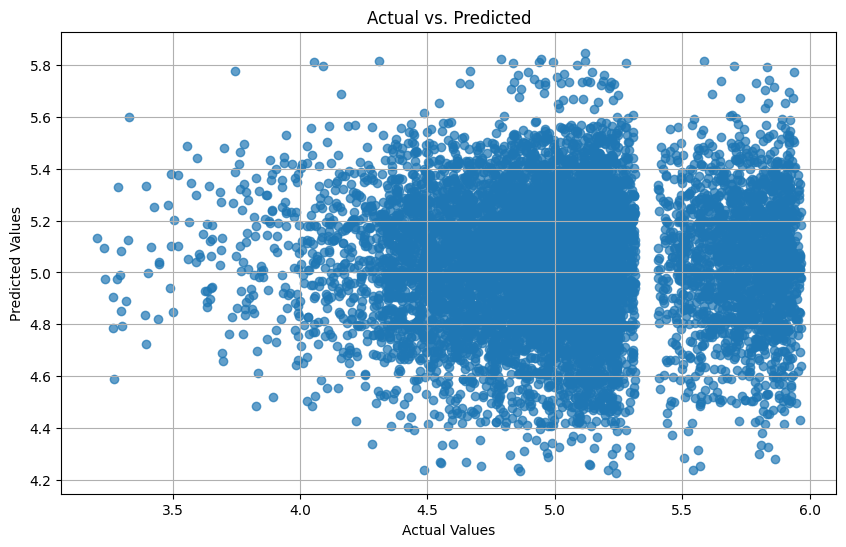

Baseline selection RMSE: 0.5217391786107505
Baseline selection MAE: 0.40813551860628566


In [ ]:
model = sm.OLS(y, X)
fit_model = model.fit()
# predict using all independent variables as features
baseline_predict = fit_model.predict(X)
df_test_y = df_test['log_Amount']
baseline_predict = baseline_predict[:len(df_test_y)]
# compute rmse and msa of baseline model predictions
baseline_mse = mean_squared_error(df_test_y, baseline_predict)
baseline_mae = mean_absolute_error(df_test_y, baseline_predict)
# displays the results of the model
print(fit_model.summary())

# plot of the regression
plt.figure(figsize=(10, 6))
plt.scatter(df_test_y, baseline_predict, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Baseline selection RMSE:", np.sqrt(baseline_mse))
print("Baseline selection MAE:", baseline_mae)

Use the step-reg library to perform backward selection on the features. Backselect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [ ]:
backselect = step_reg.backward_regression(X, y, 0.05, verbose=False)
print(backselect)

['const', 'Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Plastic Surgeon', 'Radiology', 'Resident', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']


Create a new model using our new feature set from backward selection and test it on our test data. Outputted are results of the regression and statistics.

In [ ]:
X_backselect = X[backselect]
back_model = sm.OLS(y, X_backselect)
fit_back_model = back_model.fit()
# display the results of the model
print(fit_back_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     427.0
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:43:05   Log-Likelihood:                -14104.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29496   BIC:                         2.850e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2

Compute the root mean squared error and mean absolute error of the predictions on the test data.

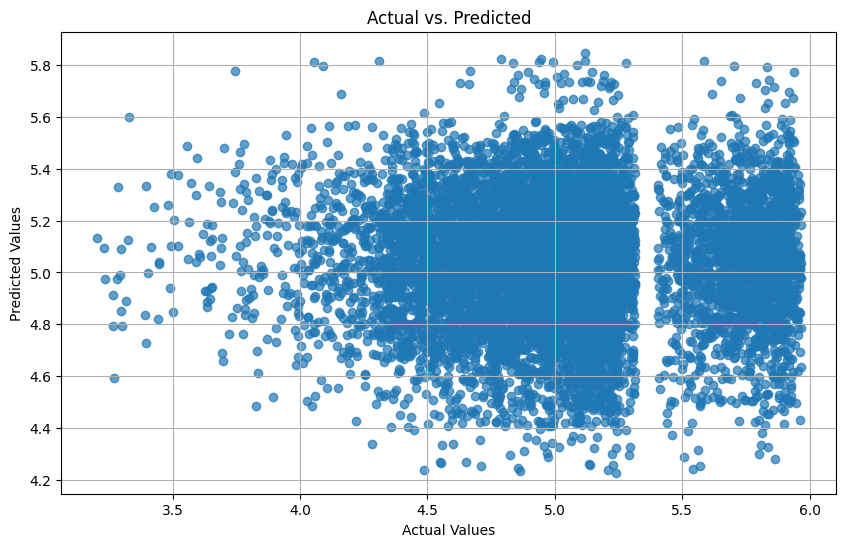

Backward selection RMSE: 0.5217251169557977
Backward selection MAE: 0.40812431181299164


In [ ]:
# make predictions using the new model with selected features from backward selection
b_y_predict = fit_back_model.predict(X_backselect)

# use the testing set
df_test_y = df_test['log_Amount']
b_y_predict = b_y_predict[:len(df_test_y)]

# calculate the root mean squared error and mean absolute error of the  predictions compared to the actual values
b_mse = mean_squared_error(df_test_y, b_y_predict)
b_mae = mean_absolute_error(df_test_y, b_y_predict)
# b_mse = mean_squared_error(y, b_y_predict)
# b_mae = mean_absolute_error(y, b_y_predict)

# plot the regression
plt.figure(figsize=(10, 6))
plt.scatter(df_test_y, b_y_predict, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Backward selection RMSE:", np.sqrt(b_mse))
print("Backward selection MAE:", b_mae)

Do the same process using the stepwise_regression library, except this time we will select our features using feature selection. In this case, forwardSelect will store a list of selected feature names sorted by significance to 'log_Amount' (highest to lowest).

In [ ]:
forwardselect = step_reg.forward_regression(X, y, 0.05, verbose=False)
# print(forwardselect)

# now create a new model with the forward selected features
# ensure that predictors are significant (i.e p-value >0.05)
X_forwardselect = X[forwardselect]
forward_model = sm.OLS(y, X_forwardselect)
fit_forward_model = forward_model.fit()
# display the results of the model
print(fit_forward_model.summary())

                            OLS Regression Results                            
Dep. Variable:             log_Amount   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.280
Method:                 Least Squares   F-statistic:                     480.3
Date:                Thu, 14 Dec 2023   Prob (F-statistic):               0.00
Time:                        20:43:12   Log-Likelihood:                -14105.
No. Observations:               29524   AIC:                         2.826e+04
Df Residuals:                   29499   BIC:                         2.847e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      3

Compute the root mean squared error and mean absolute error of the predictions on the test data.

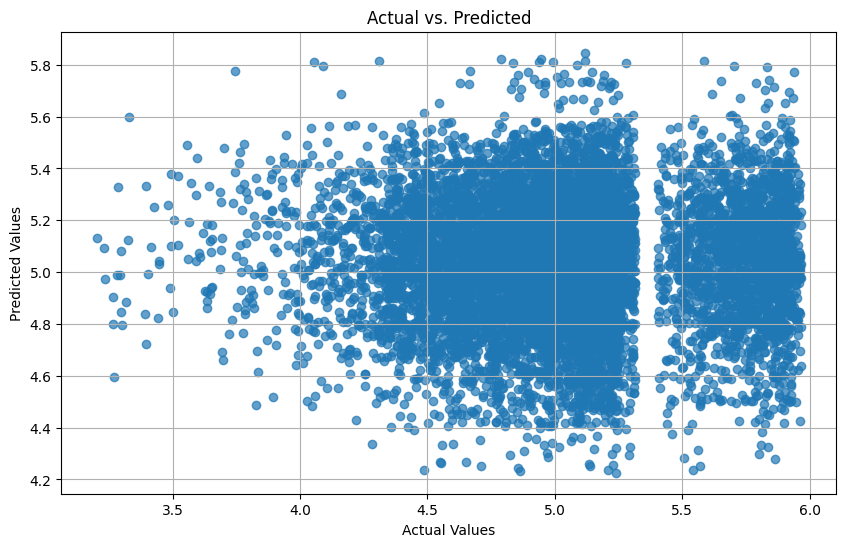

Forward selection RMSE: 0.521753033736368
Forward selection MAE: 0.4081277289841796


In [ ]:
# make predictions using the new model with selected features from forward selection
f_y_predict = fit_forward_model.predict(X_forwardselect)
f_y_predict = f_y_predict[:len(df_test_y)]
# calculate the root mean squared error and mean absolute error of the predictions compared to the actual values
f_mse = mean_squared_error(df_test_y, f_y_predict)
f_mae = mean_absolute_error(df_test_y, f_y_predict)
# f_mse = mean_absolute_error(y, f_y_predict)
# f_mse = mean_squared_error(y, f_y_predict)

# plot the regression
plt.figure(figsize=(10, 6))
plt.scatter(df_test_y, f_y_predict, alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

print("Forward selection RMSE:", np.sqrt(f_mse))
print("Forward selection MAE:", f_mae)

# Scratch Stepwise Regression

Import necessary libraries

In [ ]:
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PowerTransformer
from feature_engine.outliers import OutlierTrimmer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.random_projection import GaussianRandomProjection
from sklearn.preprocessing import PolynomialFeatures

Implement backward selection method to iteratively remove features based on a significane threshold for its p-value. Features with values that are less than 0.05 are removed.

In [ ]:
# Backward selection will iteratively remove features based on the p-value threshold
def backward_selection(X, y, threshold=0.05):
    # List of feature names
    features = list(X.columns)
    num_features = len(features)
    num_observations = len(y)

    # Iterate through the features (loop variable is not used)
    for i in range(num_features):
        # Create column for the intercept
        X_with_constant = np.column_stack((np.ones(num_observations), X))
        # Calculate weights of features in the model
        coefficients = np.linalg.lstsq(X_with_constant, y, rcond=None)[0]

        # Calculate residuals (difference between the observed and predicted values)
        residuals = y - np.dot(X_with_constant, coefficients)

        # Calculate the standard error of the coefficients
        se = np.sqrt(np.sum(residuals**2) /
                     (num_observations - num_features - 1))
        se_coefficients = se * \
            np.linalg.inv(np.dot(X_with_constant.T,
                          X_with_constant)).diagonal()
        # Handle division by zero
        se_coefficients[se_coefficients == 0] = np.inf

        # Calculate t-statistics and p-values
        t_statistics = coefficients / se_coefficients
        p_values = 2 * (1 - 0.5 * (1 + np.sign(t_statistics) *
                        np.sqrt(1 - np.exp(-2 * t_statistics**2))))
        max_p_value = p_values[1:].max()

        # If the max p-value is above the threshold, remove the feature
        if max_p_value > threshold:
            # Stores feature with largest p-value (ignoring the intercept term)
            remove_feature = features[np.argmax(p_values[1:])]
            features.remove(remove_feature)
            X = X[features]
        # All features deemed insignificant have been removed
        else:
            break
    return features

Implement forward selection method to iteratively add features based on a significane threshold for its p-value. Features with values that are greater than 0.05 are added to the feature set.

In [ ]:
# Forward selection will iteratively add features based on the p-value threshold
def forward_selection(X, y, threshold=0.05):
    # List of feature names
    features = list(X.columns)
    num_features = len(features)
    num_observations = len(y)
    selected_features = []

    # Iterate through the features (loop variable is not used)
    for i in range(num_features):
        best_p_value = np.inf
        best_feature = None

        for feature in features:
            # Add the current feature to evaluate to selected features
            X_selected = X[selected_features + [feature]]
            # Create column for the intercept
            X_with_constant = np.column_stack(
                (np.ones(num_observations), X_selected))
            # Calculate the weights of features in the model
            coefficients = np.linalg.lstsq(X_with_constant, y, rcond=None)[0]

            # Calculate residuals (difference between the observed and predicted values)
            residuals = y - np.dot(X_with_constant, coefficients)

            # Calculate the standard error (se) of the coefficients
            se = np.sqrt(np.sum(residuals**2) /
                         (num_observations - len(selected_features) - 1))
            se_coefficients = se * \
                np.linalg.inv(np.dot(X_with_constant.T,
                              X_with_constant)).diagonal()
            # Handle division by zero (caused by potential collinearity). Set to infinity, so feature will not be added.
            se_coefficients[se_coefficients == 0] = np.inf
            # Calculate t-statistics and p-values
            t_statistics = coefficients / se_coefficients
            p_value = 2 * (1 - 0.5 * (1 + np.sign(t_statistics)
                           * np.sqrt(1 - np.exp(-2 * t_statistics**2))))

            # If the p-value for the newest added feature is better, update best_feature
            if p_value[1] < best_p_value:
                best_p_value = p_value[1]
                best_feature = feature

        # If the best p_value is below the threshold, add the feature
        if best_p_value < threshold:
            selected_features.append(best_feature)
            features.remove(best_feature)
        else:
            break

    return selected_features

Create a helper functions to perform linear regression and make predictions using model.

In [ ]:
def linear_regression(X, y):  # Linear regression to get coefficients (feature weights)
    X_with_constant = np.column_stack((np.ones(len(y)), X))
    coefficients = np.linalg.lstsq(X_with_constant, y, rcond=None)[0]
    return coefficients


def predict(X, coefficients):  # Function to make predictions using the linear regression model
    X_with_constant = np.column_stack((np.ones(X.shape[0]), X))
    return np.dot(X_with_constant, coefficients)

Store files and create train, validate, and test sets.

In [ ]:
df = pd.read_csv("log10_data_train.csv")
df_validate = pd.read_csv("log10_data_validate.csv")
df_test = pd.read_csv("log10_data_test.csv")

We consider all features except for 'Amount' and 'log_Amount', then set 'log_Amount' to be the target variable. We will see which features significantly impact 'log_Amount the most'

In [ ]:
# Store features and target variable
X = df.drop(['log_Amount', 'Amount'], axis=1)
y = df['log_Amount']

Perform backward selection on the feature set.

In [ ]:
# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private']


Train the linear model using the feature set created by backward selection and make predictions using the model on the testing set.

In [ ]:
# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

Calculate metrics for backward selection. Output list of features used, metrics, and actual vs. predicted values plot.


Backward Selection Metrics:
Root Mean Squared Error: 0.39709943647678114
Mean Absolute Error: 0.31643322939296303
T-Statistic: 0.5615286668588928
P-Value 0.5744435869932845


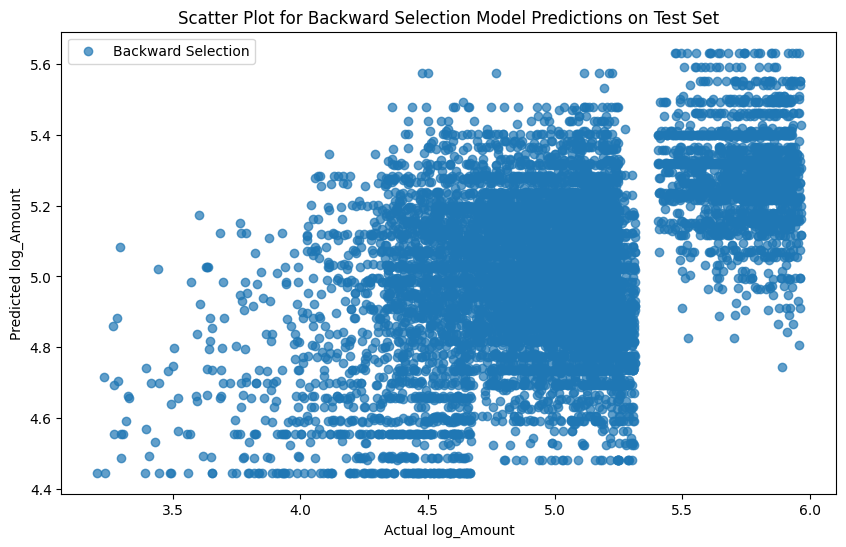

In [ ]:
# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

Perform forward selection on the feature set.

In [ ]:
# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']


Train the linear model using the feature set created by forward selection and make predictions using the model on the testing set.

In [ ]:
# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

Calculate metrics for forward selection. Output list of features used, metrics, and actual vs. predicted values plot.


Forward Selection Metrics:
Root Mean Squared Error: 0.38986819406649675
Mean Absolute Error: 0.3090991406848745
T-Statistic: 0.593074356643158
P-Value: 0.553138205510898


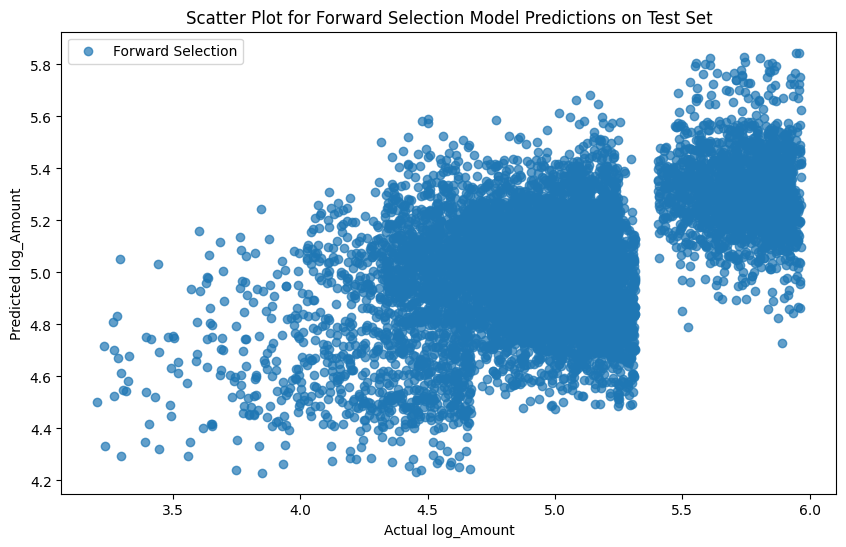

In [ ]:
# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

Outlier Trimmer

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private', 'Workers Compensation']

Backward Selection Metrics:
Root Mean Squared Error: 0.29352929071517936
Mean Absolute Error: 0.2371539729510591
T-Statistic: -0.19536158153338734
P-Value 0.8451123178857909


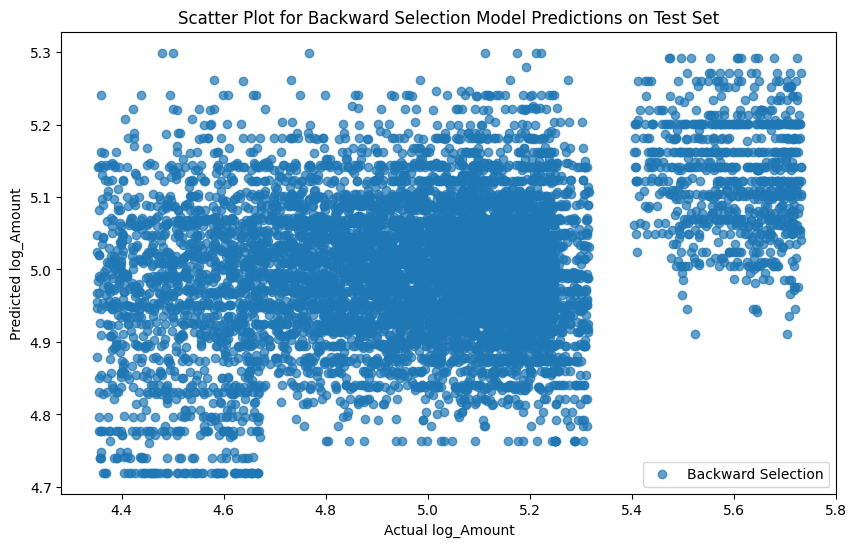



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']

Forward Selection Metrics:
Root Mean Squared Error: 0.2899315256103601
Mean Absolute Error: 0.23436765915024999
T-Statistic: -0.22923429327980513
P-Value: 0.8186896868788887


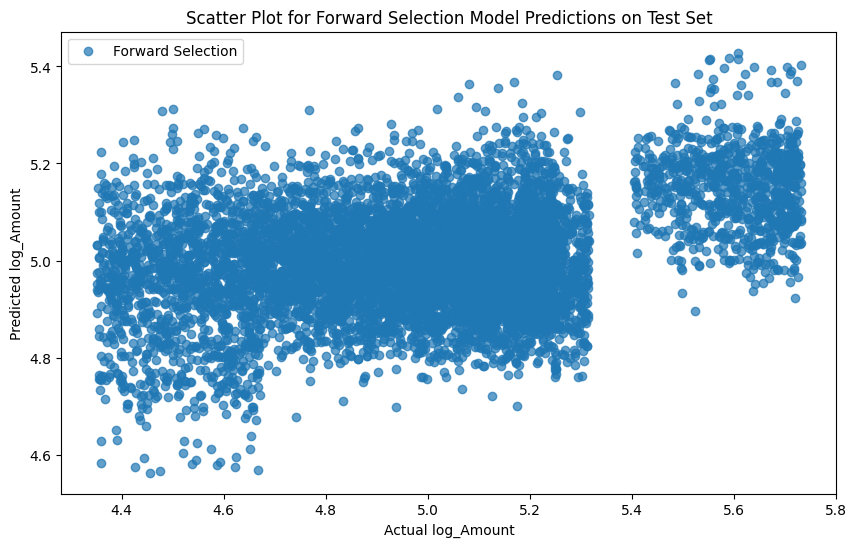

In [ ]:
df = pd.read_csv("log10_data_train.csv")
df_validate = pd.read_csv("log10_data_validate.csv")
df_test = pd.read_csv("log10_data_test.csv")

# Outlier Trimmer
ot = OutlierTrimmer(capping_method='gaussian', tail='both',
                    fold=1.5, variables=['log_Amount'])
ot.fit(df)
df = ot.transform(df)
df_test = ot.transform(df_test)

# Store features and target variable
X = df.drop(['log_Amount', 'Amount'], axis=1)
y = df['log_Amount']

# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]

# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

Power Transformer

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private']

Backward Selection Metrics:
Root Mean Squared Error: 0.3960538810215383
Mean Absolute Error: 0.315541649768746
T-Statistic: 0.5397020282412468
P-Value 0.5894086466504025


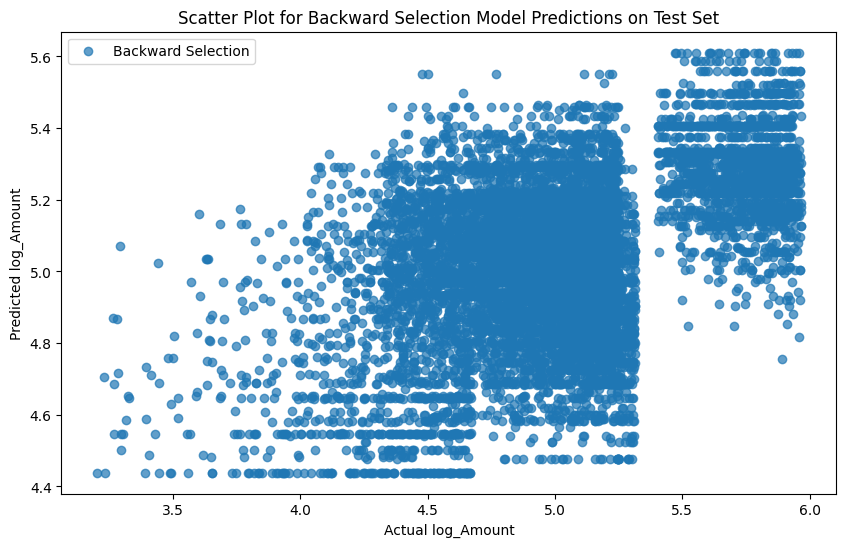



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']

Forward Selection Metrics:
Root Mean Squared Error: 0.3888123152304183
Mean Absolute Error: 0.30821124450875603
T-Statistic: 0.5721481247130135
P-Value: 0.5672281627775031


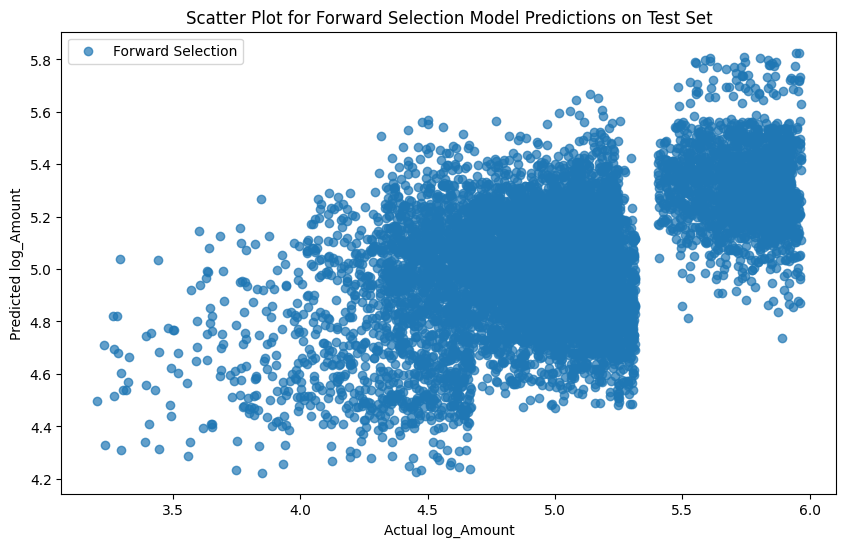

In [ ]:
df = pd.read_csv("log10_data_train.csv")
df_validate = pd.read_csv("log10_data_validate.csv")
df_test = pd.read_csv("log10_data_test.csv")

# Store features and target variable
X = df.drop(['log_Amount', 'Amount'], axis=1)
y = df['log_Amount']

# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

# Power Transformer
scaler_backward = StandardScaler()
pt_backward = PowerTransformer()

X_train_backward = pt_backward.fit_transform(
    scaler_backward.fit_transform(X_train_backward))
X_test_backward = pt_backward.transform(
    scaler_backward.transform(X_test_backward))

# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]

# Power Transformer
scaler_forward = StandardScaler()
pt_forward = PowerTransformer()

X_train_forward = pt_forward.fit_transform(
    scaler_forward.fit_transform(X_train_forward))
X_test_forward = pt_forward.transform(
    scaler_forward.transform(X_test_forward))

# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

PCA

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private']

Backward Selection Metrics:
Root Mean Squared Error: 0.434409748460649
Mean Absolute Error: 0.3458774176521339
T-Statistic: 0.7373346019240042
P-Value 0.46092768446093857


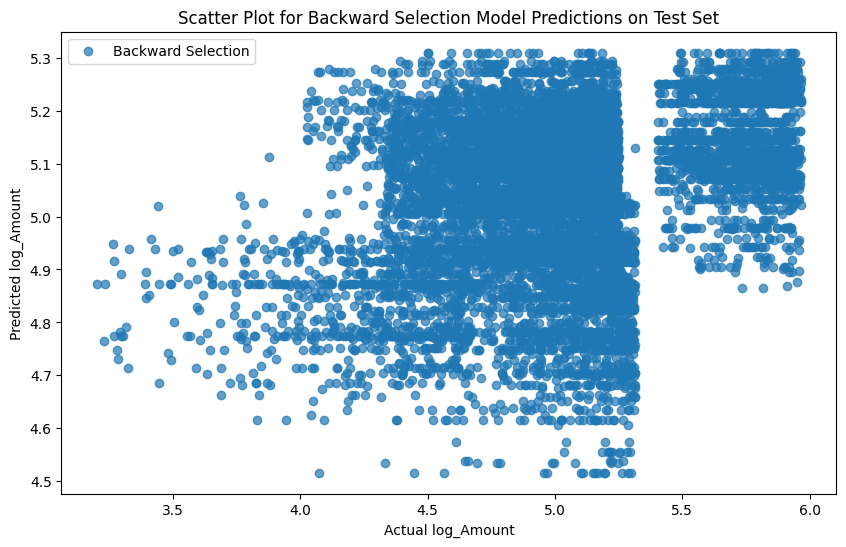



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']

Forward Selection Metrics:
Root Mean Squared Error: 0.41539719539601977
Mean Absolute Error: 0.3316783151826808
T-Statistic: 0.6336184481923772
P-Value: 0.5263372210615688


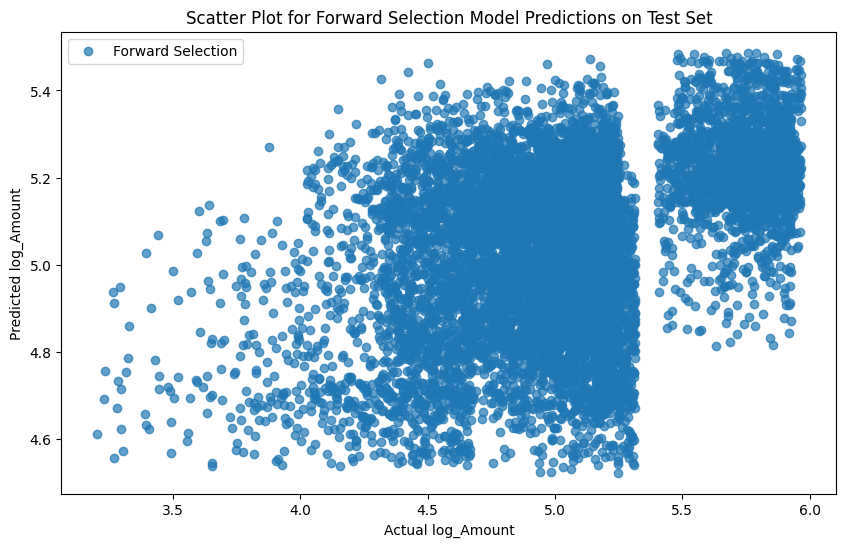

In [ ]:
# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

# PCA
scaler_backward = StandardScaler()
pca_backward = PCA(n_components=2)

X_train_backward = pca_backward.fit_transform(
    scaler_backward.fit_transform(X_train_backward))
X_test_backward = pca_backward.transform(
    scaler_backward.transform(X_test_backward))

# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]

# PCA
scaler_forward = StandardScaler()
pca_forward = PCA(n_components=2)

X_train_forward = pca_forward.fit_transform(
    scaler_forward.fit_transform(X_train_forward))
X_test_forward = pca_forward.transform(
    scaler_forward.transform(X_test_forward))

# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

Random Projection

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private']

Backward Selection Metrics:
Root Mean Squared Error: 0.43075964114722676
Mean Absolute Error: 0.336636740762581
T-Statistic: 1.144370323086886
P-Value 0.25248400690469


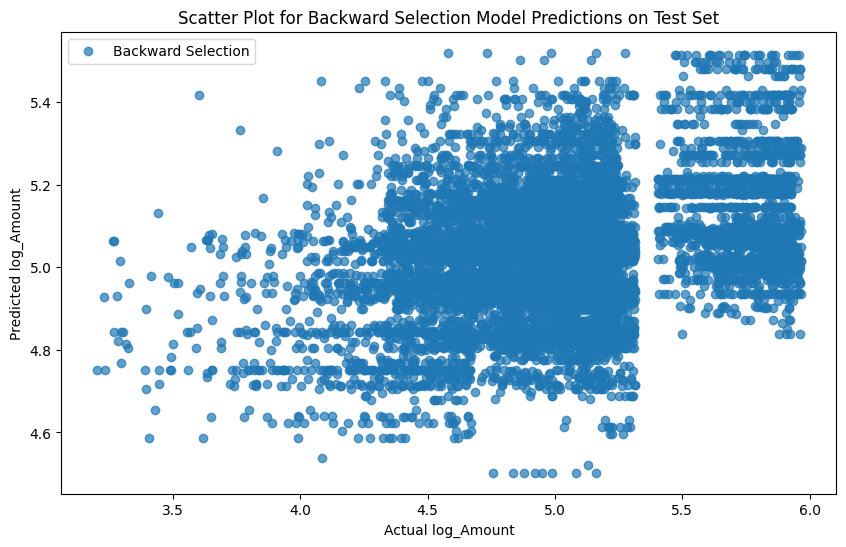



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']

Forward Selection Metrics:
Root Mean Squared Error: 0.4308594678148278
Mean Absolute Error: 0.3364893211702865
T-Statistic: 0.594778761500637
P-Value: 0.5519982034157465


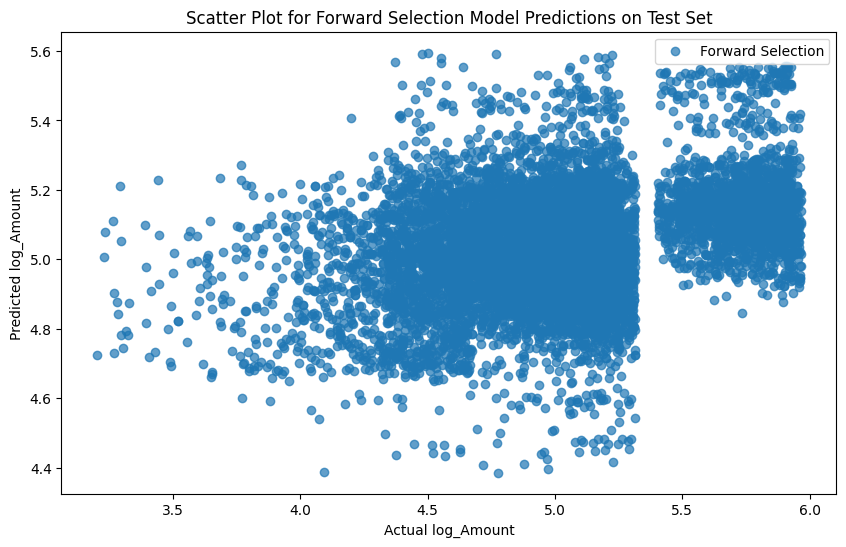

In [ ]:
# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

# Random Projection
scaler_backward = StandardScaler()
rp_backward = GaussianRandomProjection(n_components=10, random_state=42)

rp_backward.fit(X_train_backward)
X_train_backward = rp_backward.fit_transform(
    scaler_backward.fit_transform(X_train_backward))
X_test_backward = rp_backward.transform(
    scaler_backward.transform(X_test_backward))

# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]

# Random Projection
scaler_forward = StandardScaler()
rp_forward = GaussianRandomProjection(n_components=10, random_state=42)

rp_forward.fit(X_train_forward)
X_train_forward = rp_forward.fit_transform(
    scaler_forward.fit_transform(X_train_forward))
X_test_forward = rp_forward.transform(
    scaler_forward.transform(X_test_forward))

# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

Spline Transformer

Features selected from backward elimination: ['Severity', 'Private Attorney', 'Gender', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Resident', 'Urological Surgery', 'No Insurance', 'Private']

Backward Selection Metrics:
Root Mean Squared Error: 0.36316046950655695
Mean Absolute Error: 0.2873368987172316
T-Statistic: 0.2781822423493186
P-Value 0.780875387795647


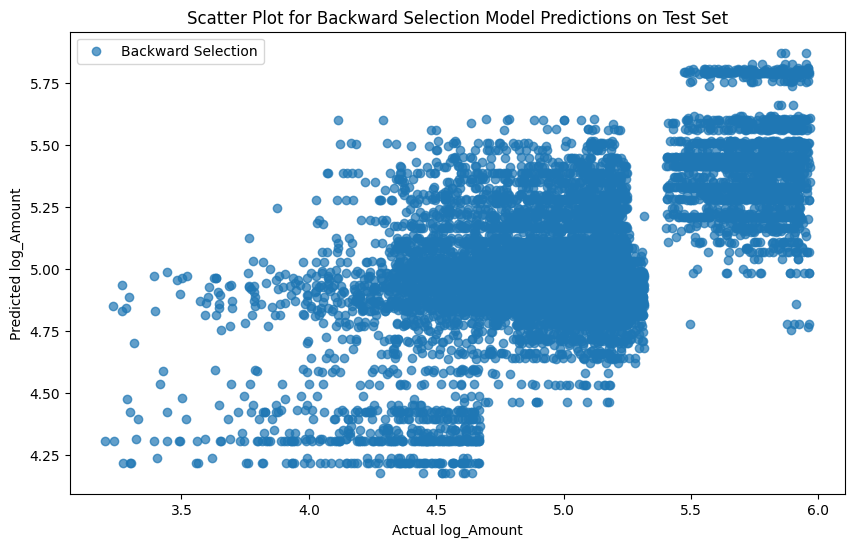



Features selected from forward selection: ['Severity', 'Age', 'Private Attorney', 'Gender', 'Anesthesiology', 'Cardiology', 'Dermatology', 'Emergency Medicine', 'Family Practice', 'General Surgery', 'Internal Medicine', 'Neurology/Neurosurgery', 'OBGYN', 'Occupational Medicine', 'Ophthamology', 'Orthopedic Surgery', 'Pathology', 'Pediatrics', 'Physical Medicine', 'Plastic Surgeon', 'Radiology', 'Resident', 'Thoracic Surgery', 'Urological Surgery', 'Medicare/Medicaid', 'No Insurance', 'Private', 'Workers Compensation', 'Divorced', 'Single', 'Married', 'Widowed']

Forward Selection Metrics:
Root Mean Squared Error: 0.3550917144946819
Mean Absolute Error: 0.2805816432954388
T-Statistic: 0.4174581025680855
P-Value: 0.6763479172801476


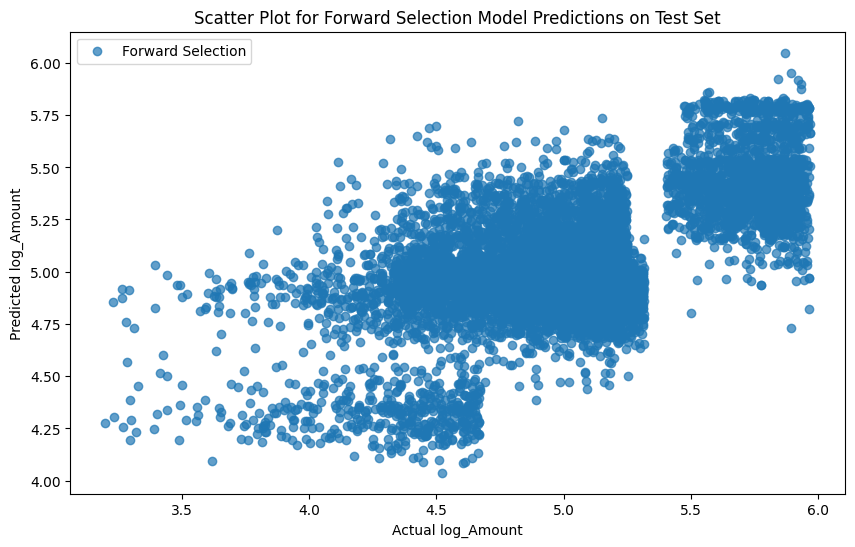

In [ ]:
# Backward selection testing
back_selected_features = backward_selection(X.copy(), y)
print("Features selected from backward elimination:", back_selected_features)

# Create a new data frame using the selected features from backward selection
X_train_backward = df[back_selected_features]
X_test_backward = df_test[back_selected_features]

# Polynomial Spline Transformer
scaler_backward = StandardScaler()
spline_backward = PolynomialFeatures(degree=2, include_bias=False)

X_train_backward = spline_backward.fit_transform(
    scaler_backward.fit_transform(X_train_backward))
X_test_backward = spline_backward.transform(
    scaler_backward.transform(X_test_backward))

# Train the model
coefficients_backward = linear_regression(
    X_train_backward, df['log_Amount'])

# Make predictions on the test set for backward selection
y_pred_test_backward = predict(X_test_backward, coefficients_backward)

# Evaluate metrics for backward selection
mse_test_backward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_backward)
mae_test_backward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_backward)
t_stat_backward, p_val_backward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_backward)

print("\nBackward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_backward))
print("Mean Absolute Error:", mae_test_backward)
print("T-Statistic:", t_stat_backward)
print("P-Value", p_val_backward)

# Scatter plot for backward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_backward,
            label='Backward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Backward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Forward selection testing
forward_selected_features = forward_selection(X.copy(), y)
print("\n\nFeatures selected from forward selection:", forward_selected_features)

# Create a new data frame using the selected features from forward selection
X_train_forward = df[forward_selected_features]
X_test_forward = df_test[forward_selected_features]

# Polynomial Spline Transformer
scaler_forward = StandardScaler()
spline_forward = PolynomialFeatures(degree=2, include_bias=False)

X_train_forward = spline_forward.fit_transform(
    scaler_forward.fit_transform(X_train_forward))
X_test_forward = spline_forward.transform(
    scaler_forward.transform(X_test_forward))

# Train the model for forward selection
coefficients_forward = linear_regression(
    X_train_forward, df['log_Amount'])

# Make predictions on the test set for forward selection
y_pred_test_forward = predict(X_test_forward, coefficients_forward)

# Evaluate metrics for forward selection
mse_test_forward = mean_squared_error(
    df_test['log_Amount'], y_pred_test_forward)
mae_test_forward = mean_absolute_error(
    df_test['log_Amount'], y_pred_test_forward)
t_stat_forward, p_val_forward = stats.ttest_ind(
    df_test['log_Amount'], y_pred_test_forward)

print("\nForward Selection Metrics:")
print("Root Mean Squared Error:", np.sqrt(
    mse_test_forward))
print("Mean Absolute Error:", mae_test_forward)
print("T-Statistic:", t_stat_forward)
print("P-Value:", p_val_forward)

# Scatter plot for forward selection
plt.figure(figsize=(10, 6))
plt.scatter(df_test['log_Amount'], y_pred_test_forward,
            label='Forward Selection', alpha=0.7)
plt.xlabel('Actual log_Amount')
plt.ylabel('Predicted log_Amount')
plt.title('Scatter Plot for Forward Selection Model Predictions on Test Set')
plt.legend()
plt.show()

# Lasso Regression

Import necessary libraries

In [ ]:
import sys
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import PowerTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import FastICA
from sklearn.preprocessing import PolynomialFeatures
from feature_engine.outliers import OutlierTrimmer

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy import stats

from sklearn.model_selection import cross_val_predict


Read in Data

In [ ]:
# file_input = sys.argv[1]

# df = pd.read_csv(file_input)

# train_suffix = '_train.csv'
# validate_suffix = '_validate.csv'
# test_suffix = '_test.csv'

df_train = pd.read_csv('log10_data_train.csv')
df_validate = pd.read_csv('log10_data_validate.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
y_test = df_test['log_Amount']

Default Lasso Regression:

Cross-Validation Results:
Mean Absolute Error (CV): 0.3099368682811276
Mean Squared Error (CV): 0.1525763734491082
2 Most Important Features:
Private Attorney: 0.1139703988210472
Severity: 0.07949332751919903


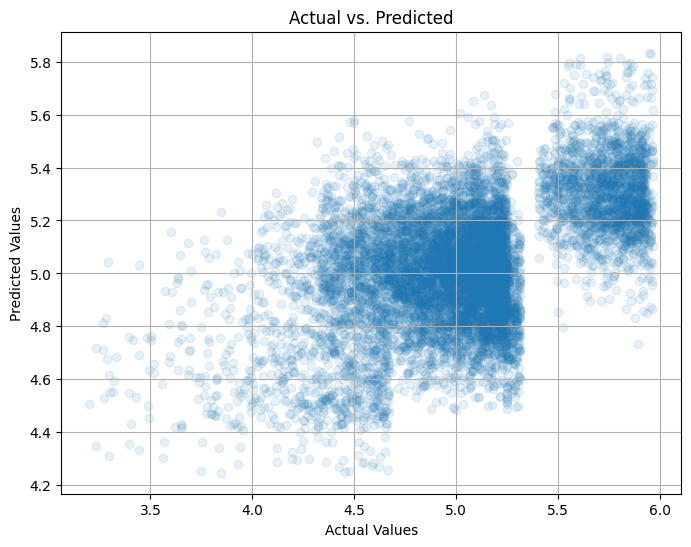

Test Results:
Mean Absolute Error (Test): 0.3091388840164066
Mean Squared Error (Test): 0.15207595546268274


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.001)

y_pred_cv = cross_val_predict(lasso, X_train_scaled, y_train, cv=10)

mae_cv = mean_absolute_error(y_train, y_pred_cv)
mse_cv = mean_squared_error(y_train, y_pred_cv)

print("Cross-Validation Results:")
print(f"Mean Absolute Error (CV): {mae_cv}")
print(f"Mean Squared Error (CV): {mse_cv}")

lasso.fit(X_train_scaled, y_train)

coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")

y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 1: Spline Transformer

2 Most Important Features:
Severity: 0.09156177088803397
Private Attorney: 0.0708047291793448


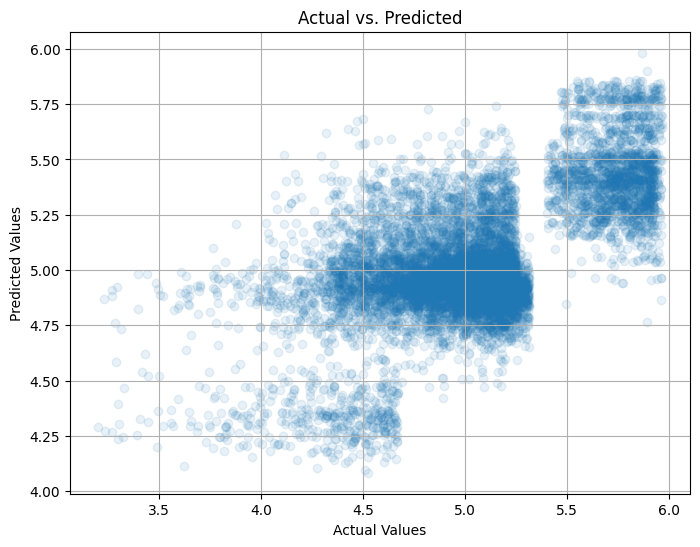

Mean Absolute Error: 0.28048675551870017
Mean Squared Error: 0.12605765375351996


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

spline_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = spline_transformer.fit_transform(X_train_scaled)
X_test_poly = spline_transformer.transform(X_test_scaled)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_poly)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Feature Implementation 2: PCA

PCA:
2 Most Important Features:
Age: -0.13238820993610423
Severity: -0.035552706643913995


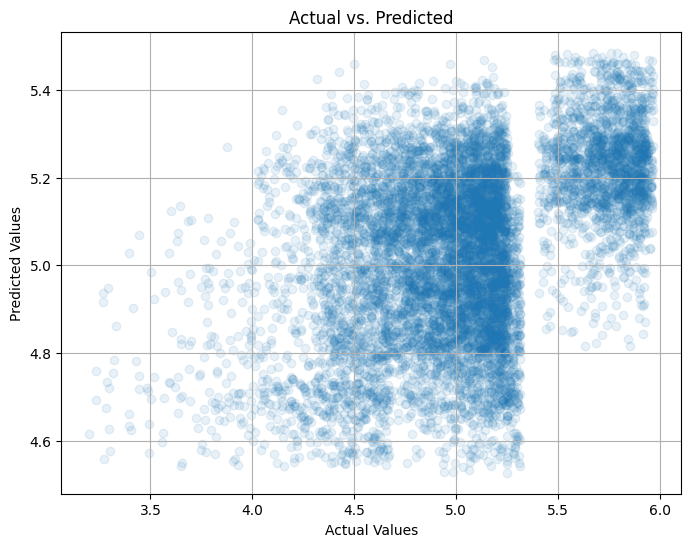

Mean Absolute Error: 0.33164011799740484
Mean Squared Error: 0.1725660426571986


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']

X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("PCA:")
n_components = 2
pca = PCA(n_components=n_components)
X_train_poly = pca.fit_transform(X_train_scaled)
X_test_poly = pca.transform(X_test_scaled)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train_poly, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_poly)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

Feature Implementation 3: Power Transformer

2 Most Important Features:
Private Attorney: 0.09883247054179418
Severity: 0.08155659538053345


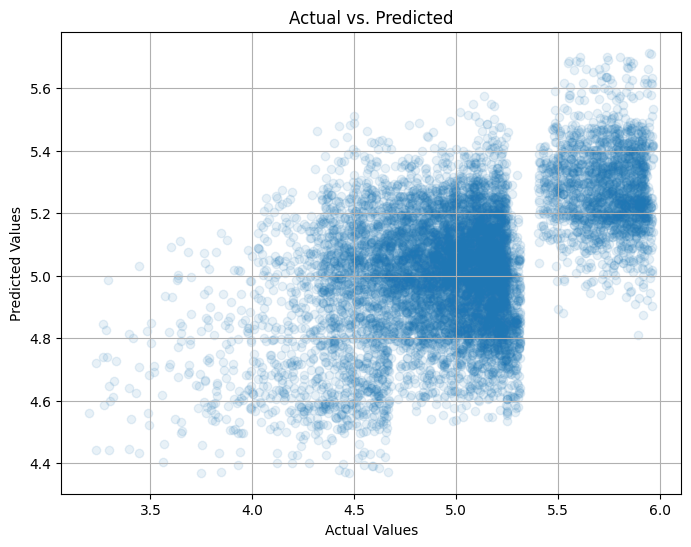

Test Results:
Mean Absolute Error (Test): 0.31130567658039515
Mean Squared Error (Test): 0.15402446509345177


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

pt = PowerTransformer()
X_train_power = pt.fit_transform(X_train)
X_test_power = pt.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_power)
X_test_scaled = scaler.transform(X_test_power)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 4: Outlier Trimming

2 Most Important Features:
Severity: 0.03444666196467667
OBGYN: 0.02728794274630417


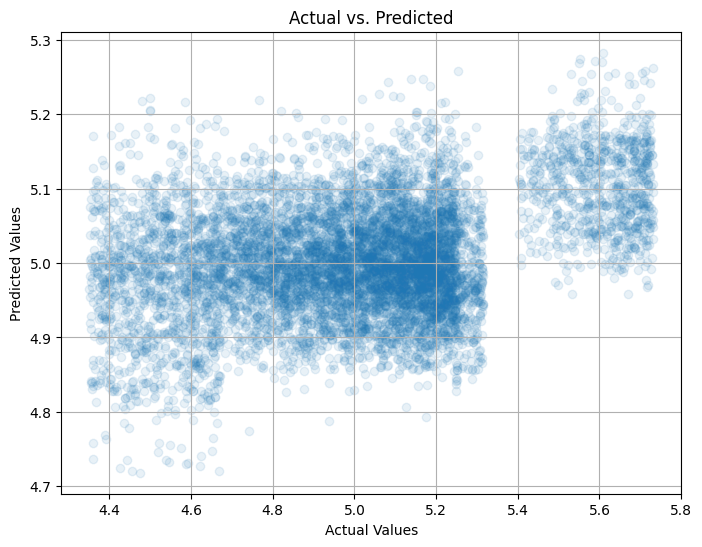

Test Results:
Mean Absolute Error (Test): 0.23635460234748418
Mean Squared Error (Test): 0.08599339589105522


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel ("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

Feature Implementation 5: t-SNE

2 Most Important Features:
Age: -0.0028817581478506327
Severity: -0.0006196059985086322


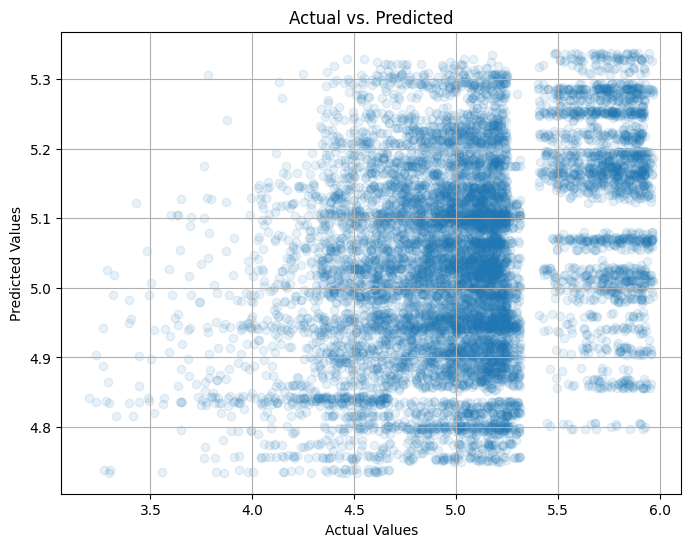

Test Results:
Mean Absolute Error (Test): 0.3419457507406272
Mean Squared Error (Test): 0.19071807429800555


In [ ]:
df_train = pd.read_csv('log10_data_train.csv')
df_test = pd.read_csv('log10_data_test.csv')

X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 2
tsne = TSNE(n_components=n_components, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_tsne, y_train)
coefficients = lasso.coef_
feature_names = X_train.columns

feature_coefficients = list(zip(feature_names, coefficients))

feature_coefficients.sort(key=lambda x: abs(x[1]), reverse=True)

print("2 Most Important Features:")
for feature, coefficient in feature_coefficients[:2]:
    print(f"{feature}: {coefficient}")
y_pred = lasso.predict(X_test_tsne)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Test Results:")
print(f"Mean Absolute Error (Test): {mae}")
print(f"Mean Squared Error (Test): {mse}")

# K-Nearest Neighbors Regression


### KNN Sklearn Implementation

Import libraries and read in testing and training data

In [ ]:
import pandas as pd
import scipy.stats as stats
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from sklearn.random_projection import GaussianRandomProjection
from feature_engine.outliers import OutlierTrimmer
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score # used to evaluate the quality of model for comparison purposes
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

Create train and test sets

In [ ]:
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

Standardize training and test data

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

Find best K using grid search


In [ ]:
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

Fit K nearest neighbors

In [ ]:
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

Calculate mae, rmse, T-Stat, P-Val

Mean Absolute Error:  0.25478058122209735
Root Mean Squared Error:  0.32952938239974544
T-Statistic:  -1.013743600773849
P-Value:  0.31071757500581204


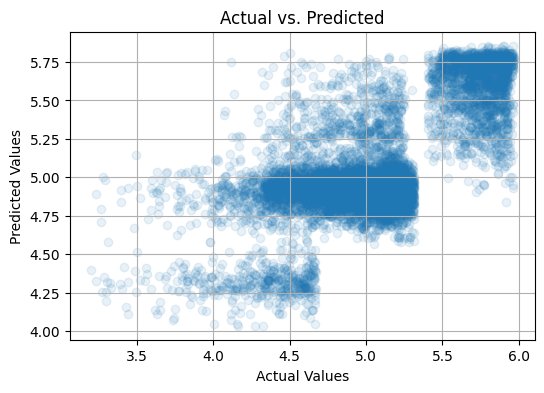

In [ ]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

### Feature implementations

Power Transformer

Power Transformer
Mean Absolute Error:  0.25565577042193066
Root Mean Squared Error:  0.3304699206296928
T-Statistic:  -1.028832543134861
P-Value:  0.30357101448505036


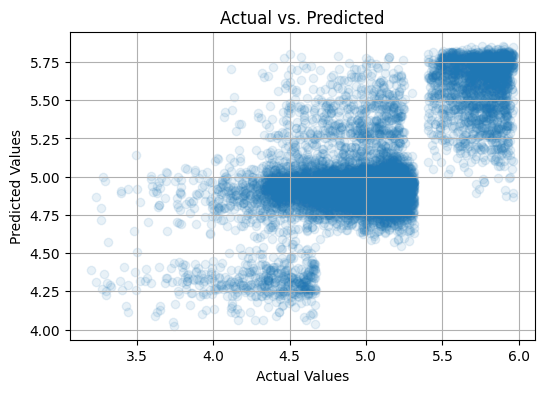

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

pt = PowerTransformer()
df_train_new = pt.fit_transform(df_train)
df_test_new = pt.transform(df_test)

#Create train and test sets for power transformer
X_train = pd.DataFrame(df_train_new, columns=df_train.columns).drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = pd.DataFrame(df_test_new, columns=df_test.columns).drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Power Transformer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Outlier Trimmer


Outlier Trimmer
Mean Absolute Error:  0.21040359691782393
Root Mean Squared Error:  0.26145562749035195
T-Statistic:  -1.5147572503819158
P-Value:  0.12985321846184855


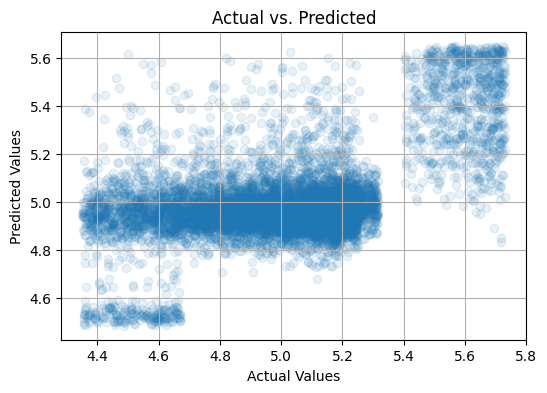

In [ ]:

df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Outlier Trimmer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()


PCA

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("PCA")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


PCA
Mean Absolute Error:  0.29197969943627416
Root Mean Squared Error:  0.37633805917769836
T-Statistic:  -0.2656825343247369
P-Value:  0.790486498377054


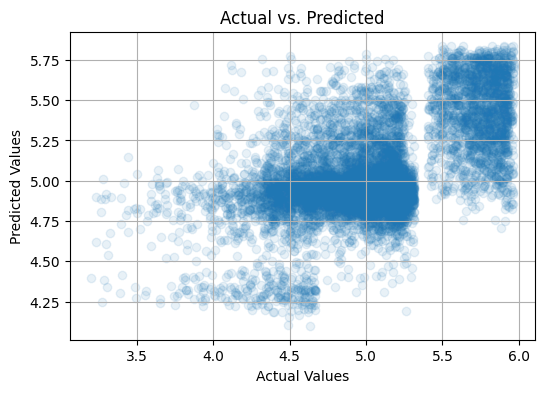

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Factor Analysis


In [ ]:

df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


#Factor Analysis
fa = FactorAnalyzer()
fa.fit(X_train)
ev, v = fa.get_eigenvalues()
count = (ev > 1).sum()

fa = FactorAnalyzer(n_factors=count)
fa.fit(X_train)
X_train = fa.transform(X_train)
X_test = fa.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Factor Analysis")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)



Factor Analysis
Mean Absolute Error:  0.3830134146201314
Root Mean Squared Error:  0.49180437314240916
T-Statistic:  36.4374129153289
P-Value:  2.2844816386006e-281


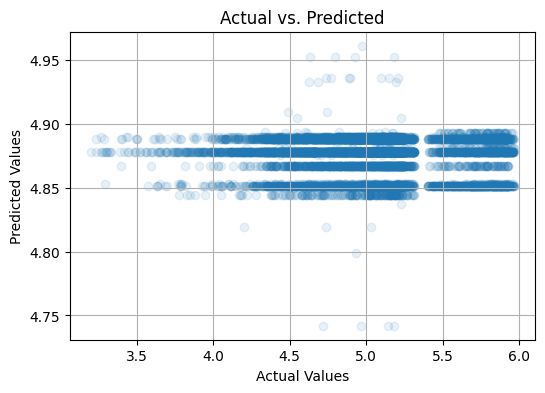

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

Random Projection

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_sc)
X_test_sc = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test_sc)


#Random Projection
rp = GaussianRandomProjection(n_components=24,random_state=42)
rp.fit(X_train)
X_train = rp.transform(X_train)
X_test = rp.transform(X_test)

#Find best K using grid search
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
knn = KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)
model.fit(X_train, y_train)
params = model.best_params_

#Fit K nearest neighbors
model_knn = KNeighborsRegressor(n_neighbors=params.get('n_neighbors'))
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)


#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Random Projection")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

Random Projection
Mean Absolute Error:  0.2544239588947029
Root Mean Squared Error:  0.32930952028506016
T-Statistic:  -1.2084850945166026
P-Value:  0.22687524449333243


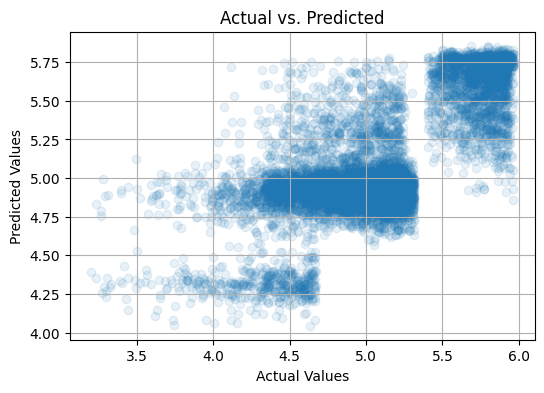

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

### KNN Regression from scratch

In [ ]:
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from sklearn.random_projection import GaussianRandomProjection
from feature_engine.outliers import OutlierTrimmer
from scipy.spatial import KDTree
from sklearn.metrics import mean_squared_error, mean_absolute_error # used to evaluate the quality of model for comparison purposes
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
class knnRegressor:
    def __init__(self, k=5):
        self.k = k
        self.X_train = None
        self.y_train = None
        self.kd_tree = None
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.kd_tree = KDTree(X)
    def predict(self, X):
        dd, ii = self.kd_tree.query(X, k=self.k)
        predictions = []
        for i in ii:
            nearest_neighbors = self.y_train.iloc[i]
            prediction = nearest_neighbors.mean()
            predictions.append(prediction)
        return np.array(predictions)

# Define function to find the best k
def bestK(X_train, X_test, y_train, y_test):
    k_values = np.linspace(2,20,num=19,dtype=int)
    mse = []
    for k in k_values:
        model_knn = knnRegressor(k=k)
        model_knn.fit(X_train,y_train)
        predictions = model_knn.predict(X_test)
        mse.append(((y_test - predictions) ** 2).mean())
    best_k = k_values[np.argmin(mse)]
    return best_k

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

Create train and test sets

In [ ]:
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

Standardize training and test data

In [ ]:
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

Find best K using implemented function

In [ ]:
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Fit K nearest neighbors

In [ ]:
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

Calculate mae, rmse, T-stat, P-val

KNN from scratch
Mean Absolute Error:  0.25470289945266017
Root Mean Squared Error:  0.32979378455219427
T-Statistic:  -1.388722527074941
P-Value:  0.16493285561038773


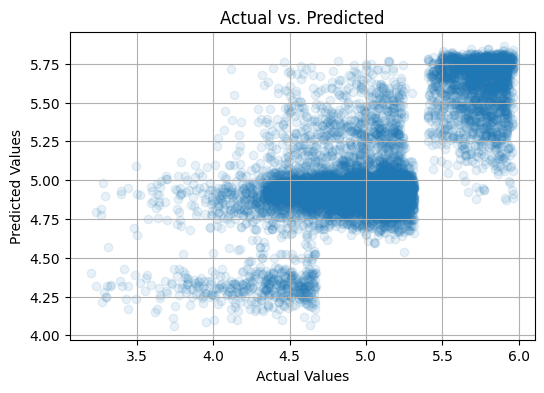

In [ ]:
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("KNN from scratch")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

### Feature Implementation
from scratch implementation

**Power Transformer**

Power Transformer
Mean Absolute Error:  0.25500123312745415
Root Mean Squared Error:  0.3298957280786482
T-Statistic:  -1.3217314234532913
P-Value:  0.18627296310619879


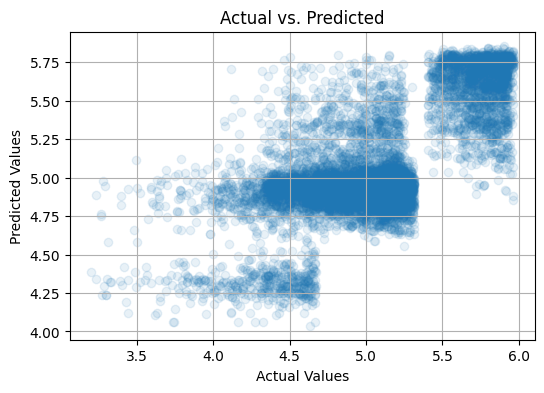

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

pt = PowerTransformer()
df_train_new = pt.fit_transform(df_train)
df_test_new = pt.transform(df_test)

#Create train and test sets for power transformer
X_train = pd.DataFrame(df_train_new, columns=df_train.columns).drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = pd.DataFrame(df_test_new, columns=df_test.columns).drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

#Find best K using implemented function
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
#Fit K nearest neighbors
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Power Transformer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)

plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

**Outlier Trimmer**

Outlier Trimmer
Mean Absolute Error:  0.21030970214298653
Root Mean Squared Error:  0.26177788406088237
T-Statistic:  -1.2582415632056718
P-Value:  0.20832237319586297


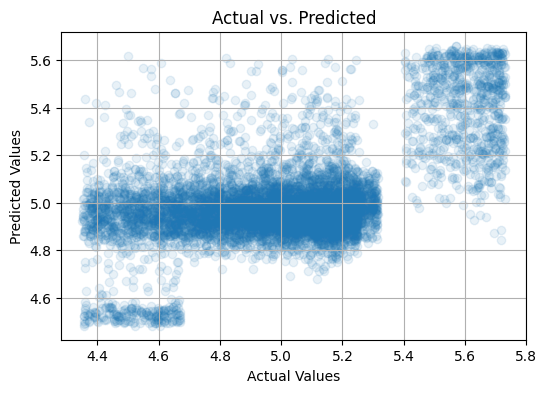

In [ ]:

df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

ot = OutlierTrimmer(capping_method='gaussian', tail='both', fold=1.5, variables=['log_Amount'])
ot.fit(df_train)
df_train = ot.transform(df_train)
df_test = ot.transform(df_test)

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

#Find best K using function implementation
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

#Fit K nearest neighbors
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Outlier Trimmer")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

**PCA**

PCA
Mean Absolute Error:  0.2911794252273201
Root Mean Squared Error:  0.3756401728154636
T-Statistic:  -0.1749797369041647
P-Value:  0.8610973554289278


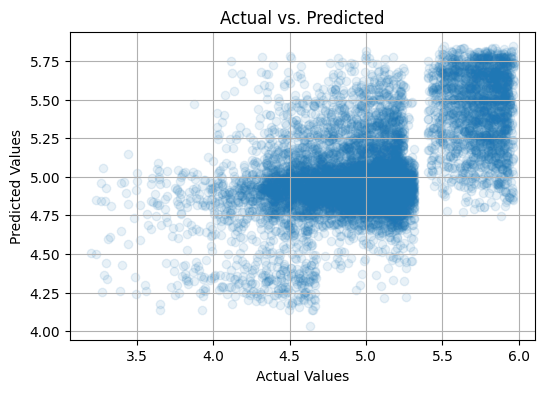

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

#PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

#Find best K using function implementation
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

#Fit K nearest neighbors
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("PCA")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

**Factor Analysis**

Factor Analysis
Mean Absolute Error:  0.25748758297643465
Root Mean Squared Error:  0.3315594813362223
T-Statistic:  -0.6498195772050984
P-Value:  0.515816355391236


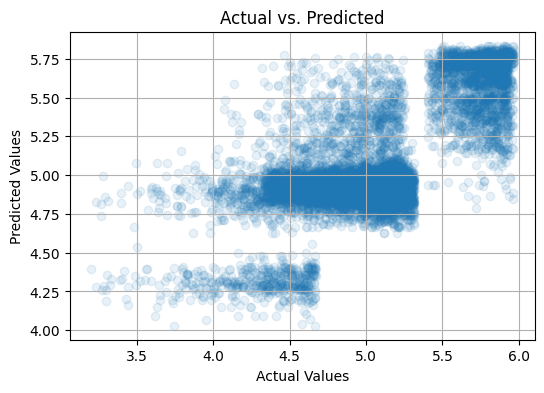

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

#Factor Analysis
fa = FactorAnalyzer()
fa.fit(X_train)
ev, v = fa.get_eigenvalues()
count = (ev > 1).sum()

fa = FactorAnalyzer(n_factors=count)
fa.fit(X_train)
X_train = fa.transform(X_train)
X_test = fa.transform(X_test)

#Find best K using function implementation
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

#Fit K nearest neighbors
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Factor Analysis")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()

**Random Projection**

Random Projection
Mean Absolute Error:  0.25463321409393946
Root Mean Squared Error:  0.32960226785890306
T-Statistic:  -1.206783577360512
P-Value:  0.22753000609323418


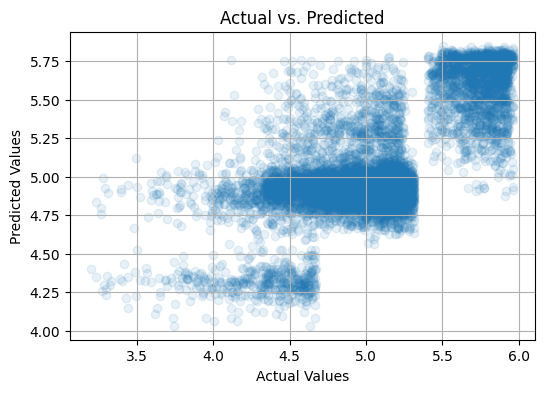

In [ ]:
df_train = pd.read_csv("log10_data_train.csv")
df_test = pd.read_csv("log10_data_test.csv")

#Create train and test sets
X_train = df_train.drop(columns=['Amount', 'log_Amount'])
y_train = df_train['log_Amount']
X_test = df_test.drop(columns=['Amount', 'log_Amount'])
y_test = df_test['log_Amount']

#Standardize training and test data
mean = X_train.mean()
std = X_train.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

#Random Projection
rp = GaussianRandomProjection(n_components=24,random_state=42)
rp.fit(X_train)
X_train = rp.transform(X_train)
X_test = rp.transform(X_test)

#Find best K using function implementation
best_k = bestK(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

#Fit K nearest neighbors
model_knn = knnRegressor(k=best_k)
model_knn.fit(X=X_train, y=y_train)
predict = model_knn.predict(X=X_test)

#Calculate mse, rmse, T stat, P Val
mse = mean_squared_error(y_test, predict)
mae = mean_absolute_error(y_test, predict)
rmse = sqrt(mse)
t_stat, p_val = stats.ttest_ind(y_test, predict)
print("Random Projection")
print("Mean Absolute Error: ", mae)
print("Root Mean Squared Error: ", rmse)
print("T-Statistic: ", t_stat)
print("P-Value: ", p_val)


plt.figure(figsize=(6, 4))
plt.scatter(y_test, predict, alpha=0.1)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted")
plt.grid(True)
plt.show()